<b><font size="6">Predicting obesity level</font></b><br><br>

In [78]:
#import libraries

# Libraries for data exploration, wrangling and visualization and for statistic measures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import chi2_contingency

# Enable experimental features of Scikit-learn
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv

# Outlier Detectors
from sklearn.neighbors import LocalOutlierFactor

# Imputing
from sklearn.impute import KNNImputer, IterativeImputer

# Sklearn Utilities
from sklearn.utils.class_weight import compute_class_weight

# Model selection methods
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter Optimizers
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV

# Post-hoc Explaination Algorithms
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="">

# 1. Data importation

</a>


<img src="../image/step1.png" style="height:60px">

In [79]:
# Load the data
obesity_train_raw = pd.read_csv('../data/obesity_train.csv')

In [80]:
obesity_train_raw.head(10)

,id,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,marrital_status,meals_perday,...,parent_overweight,physical_activity_perweek,region,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level
0,1,21.0,Never,no,up to 5,Sometimes,Female,1.62,NaN,3.0,...,yes,NaN,LatAm,3.0,no,Public,Sometimes,1 to 2,64.0,Normal_Weight
1,2,23.0,Frequently,no,up to 5,Sometimes,Male,1.80,NaN,3.0,...,yes,3 to 4,LatAm,0.0,no,Public,Sometimes,1 to 2,77.0,Normal_Weight
2,3,NaN,Frequently,no,up to 2,Sometimes,Male,1.80,NaN,3.0,...,no,3 to 4,LatAm,2.0,no,Walk,Always,1 to 2,87.0,Overweight_Level_I
3,4,22.0,Sometimes,no,up to 2,Sometimes,Male,1.78,NaN,1.0,...,no,NaN,LatAm,3.0,no,Public,Sometimes,1 to 2,90.0,Overweight_Level_II
4,5,22.0,Sometimes,no,up to 2,Sometimes,Male,1.64,NaN,3.0,...,no,5 or more,LatAm,3.0,no,Public,Sometimes,1 to 2,53.0,Normal_Weight
5,6,24.0,Frequently,yes,up to 5,Sometimes,Male,1.78,NaN,3.0,...,yes,1 to 2,LatAm,2.0,no,Public,Always,1 to 2,64.0,Normal_Weight
6,7,21.0,Sometimes,yes,up to 5,Frequently,Female,1.72,NaN,3.0,...,yes,3 to 4,NaN,2.0,no,Public,Sometimes,1 to 2,80.0,Overweight_Level_II
7,8,22.0,Sometimes,no,up to 2,Sometimes,Male,1.65,NaN,3.0,...,no,3 to 4,LatAm,1.0,no,Public,Always,more than 2,56.0,Normal_Weight
8,9,41.0,Frequently,yes,up to 5,Sometimes,Male,1.80,NaN,3.0,...,no,3 to 4,LatAm,0.0,no,Car,Sometimes,1 to 2,99.0,Obesity_Type_I
9,10,27.0,Sometimes,yes,up to 2,Sometimes,Male,1.93,NaN,1.0,...,yes,1 to 2,LatAm,2.0,no,Public,Sometimes,less than 1,102.0,Overweight_Level_II


<a class="anchor" id="">

# 2. Data exploration and understanding

</a>

<img src="../image/step2.png" style="height:60px">

Remember, this step is very important as it is at this stage that you will really look into the data that you have. Generally speaking, if you do well at this stage, the following stages will be very smooth.

Moreover, you should also take the time to find meaningful patterns on the data: what interesting relationships can be found between the variables and how can that knowledge be inform your future decisions.

In [81]:
# Display information about the training dataset
obesity_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1611 non-null   int64  
 1   age                        1545 non-null   float64
 2   alcohol_freq               1575 non-null   object 
 3   caloric_freq               1591 non-null   object 
 4   devices_perday             1589 non-null   object 
 5   eat_between_meals          1552 non-null   object 
 6   gender                     1591 non-null   object 
 7   height                     1597 non-null   float64
 8   marrital_status            0 non-null      float64
 9   meals_perday               1602 non-null   float64
 10  monitor_calories           1572 non-null   object 
 11  parent_overweight          1591 non-null   object 
 12  physical_activity_perweek  1046 non-null   object 
 13  region                     1544 non-null   objec

In [82]:
# Descriptive statistics for numerical variables
numerical_columns = ['age', 'height', 'weight', 'meals_perday', 'siblings']
print("Descriptive statistics for numerical variables:")
print(obesity_train_raw[numerical_columns].describe())

Descriptive statistics for numerical variables:
               age       height       weight  meals_perday     siblings
count  1545.000000  1597.000000  1558.000000   1602.000000  1599.000000
mean     24.344984     1.704108    86.956354      2.684145     1.500938
std       6.474498     0.095567    26.072339      0.817584     1.132562
min       6.000000     1.290000    32.000000      1.000000     0.000000
25%      20.000000     1.630000    67.000000      3.000000     0.000000
50%      23.000000     1.700000    83.000000      3.000000     2.000000
75%      26.000000     1.770000   107.000000      3.000000     3.000000
max      88.000000     2.190000   193.000000      4.000000     3.000000


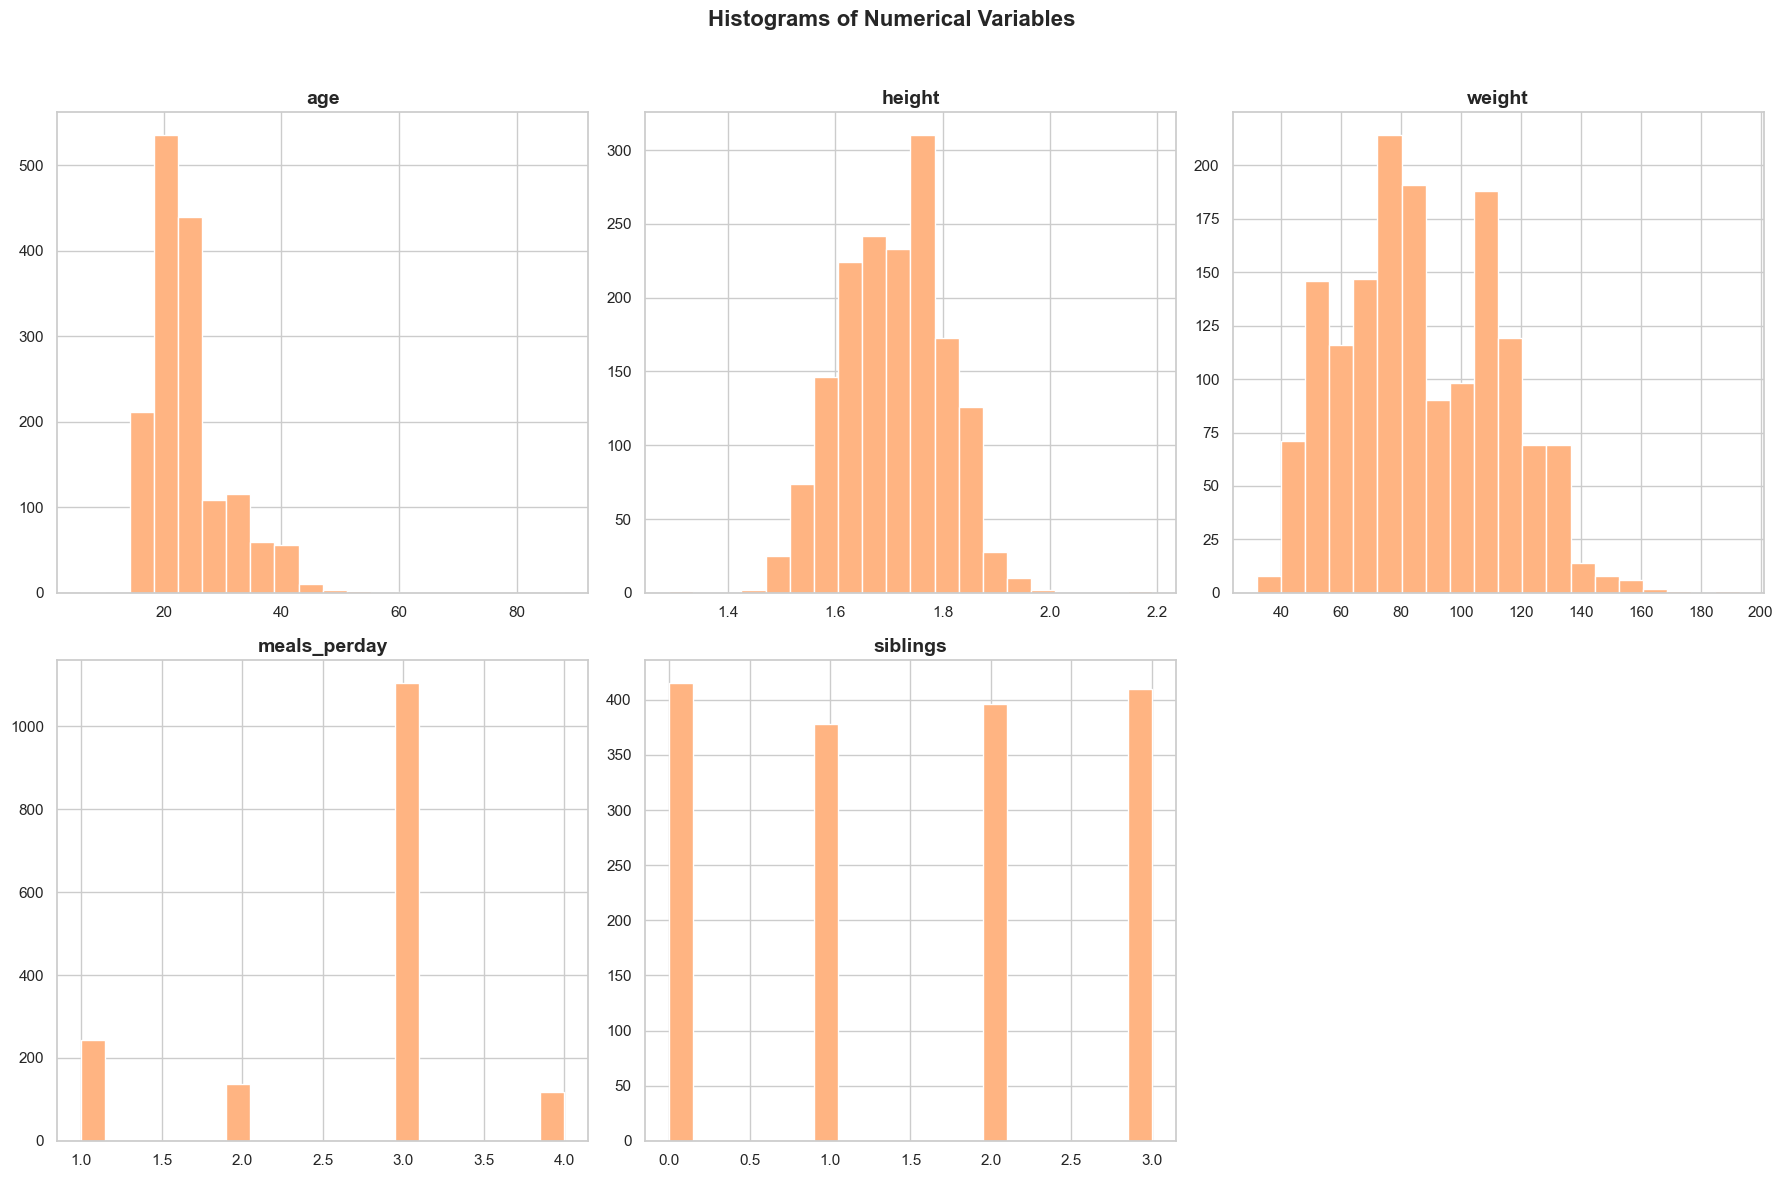

In [83]:
# Set aesthetic plot styles and color palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("pastel")

# Create subplots for histograms of numerical variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle("Histograms of Numerical Variables", fontsize=16, fontweight='bold')

for i, column in enumerate(numerical_columns):
    row, col = divmod(i, 3)
    obesity_train_raw[column].hist(bins=20, ax=axes[row, col], color=palette[1])
    axes[row, col].set_title(column, fontsize=14, fontweight='bold')

# Remove empty subplot if the number of numerical columns is less than the grid size
if len(numerical_columns) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


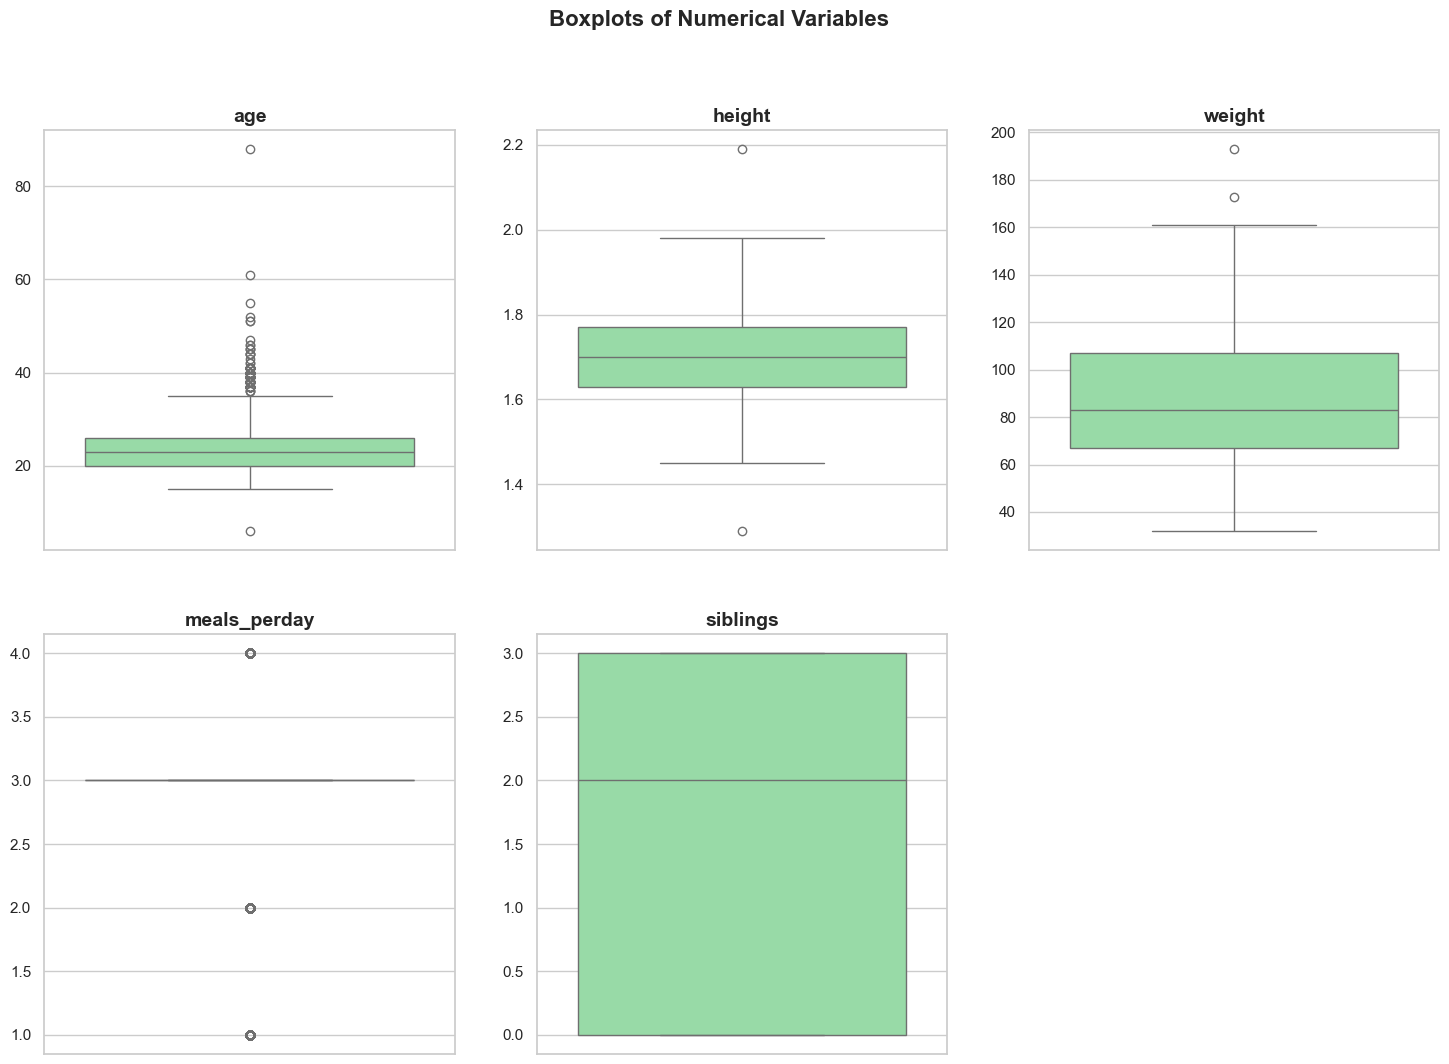

In [84]:
# Separate boxplots for each numerical variable with customization on a single canvas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle("Boxplots of Numerical Variables", fontsize=16, fontweight='bold')

for i, column in enumerate(numerical_columns):
    row, col = divmod(i, 3)
    sns.boxplot(data=obesity_train_raw, y=column, color=palette[2], ax=axes[row, col])
    axes[row, col].set_title(column, fontsize=14, fontweight='bold')
    axes[row, col].set_ylabel(None)

# Remove empty subplot if the number of numerical columns is less than the grid size
if len(numerical_columns) < 6:
    fig.delaxes(axes[1, 2])

plt.show()

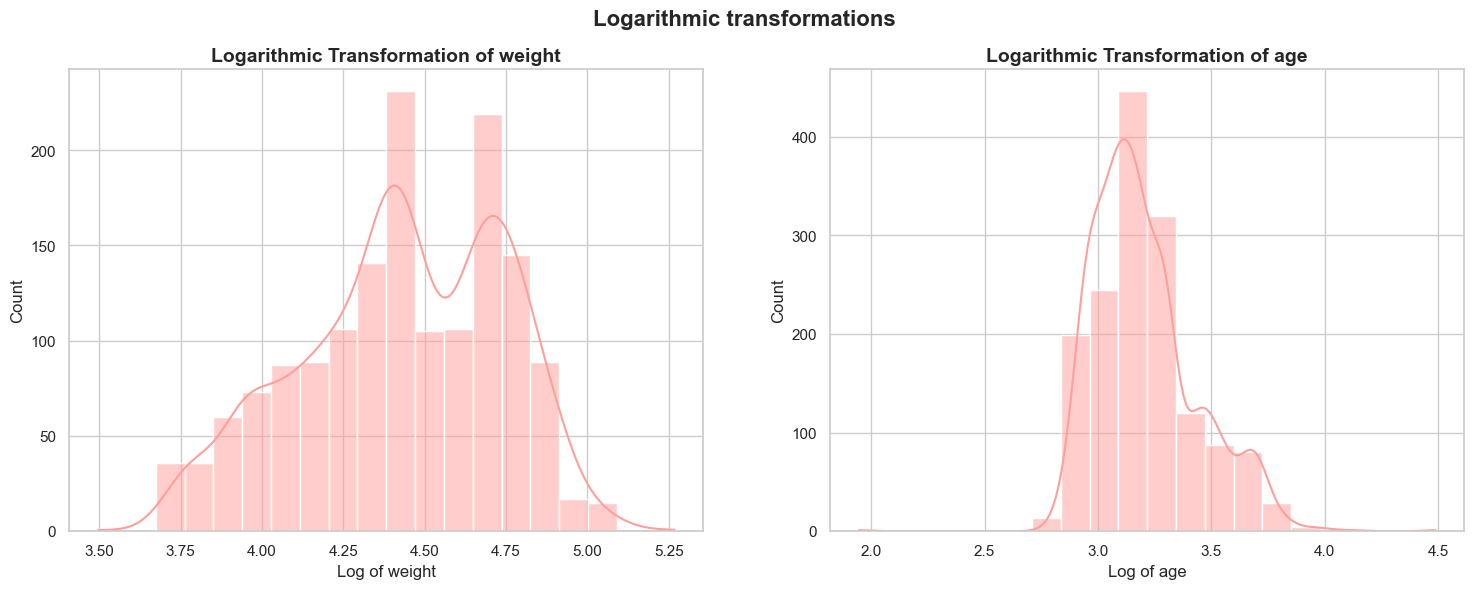

In [85]:
# Logarithmic transformation for weight and age variables

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle("Logarithmic transformations", fontsize=16, fontweight='bold')

log_transform_columns = ['weight', 'age']  # Example variables to transform

for i, column in enumerate(log_transform_columns):
    sns.histplot(np.log1p(obesity_train_raw[column]), bins=20, kde=True, color=palette[3], ax=axes[i])
    axes[i].set_title(f'Logarithmic Transformation of {column}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'Log of {column}', fontsize=12)

plt.show()

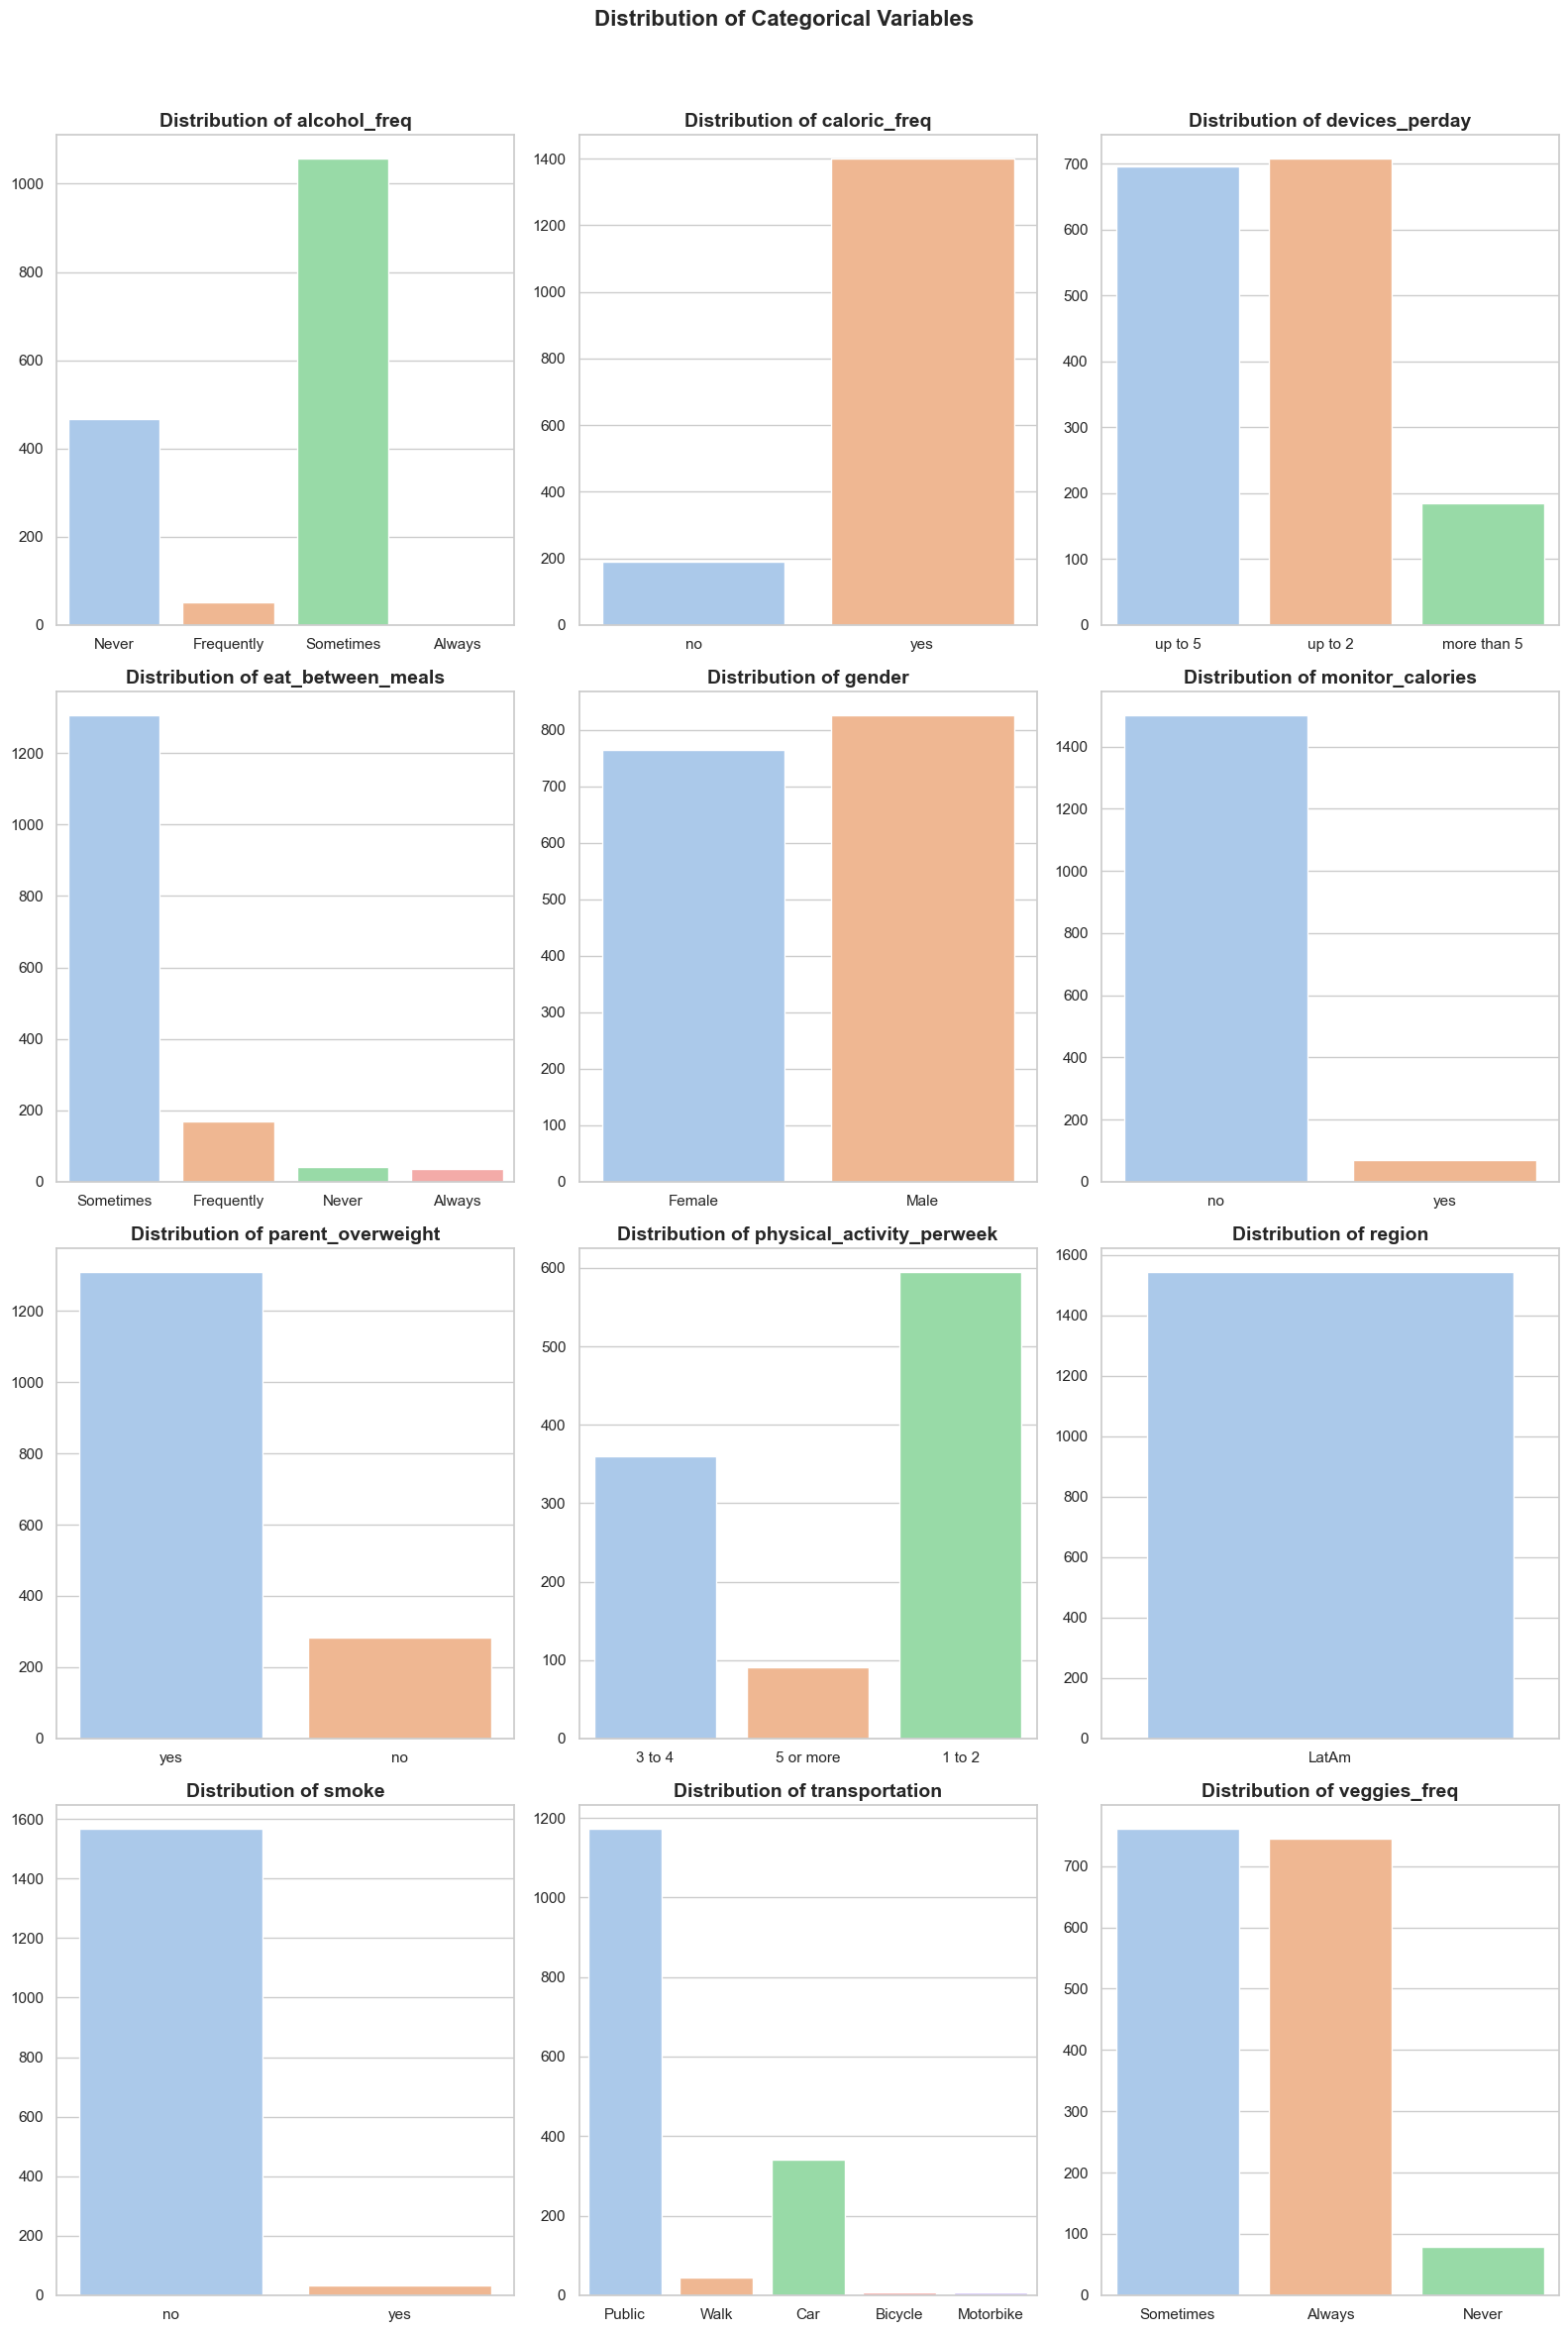

In [86]:
# Ordered countplots for categorical variables

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 24))
fig.suptitle('Distribution of Categorical Variables', fontsize=16, fontweight='bold')

for ax, var in zip(axes.flatten(), obesity_train_raw.select_dtypes(include='object').columns):
    sns.countplot(x=var, data=obesity_train_raw, palette="pastel", ax=ax)
    ax.set_title(f'Distribution of {var}', fontsize=14, fontweight='bold')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

# Remove any empty subplots
for i in range(len(obesity_train_raw.select_dtypes(include='object').columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


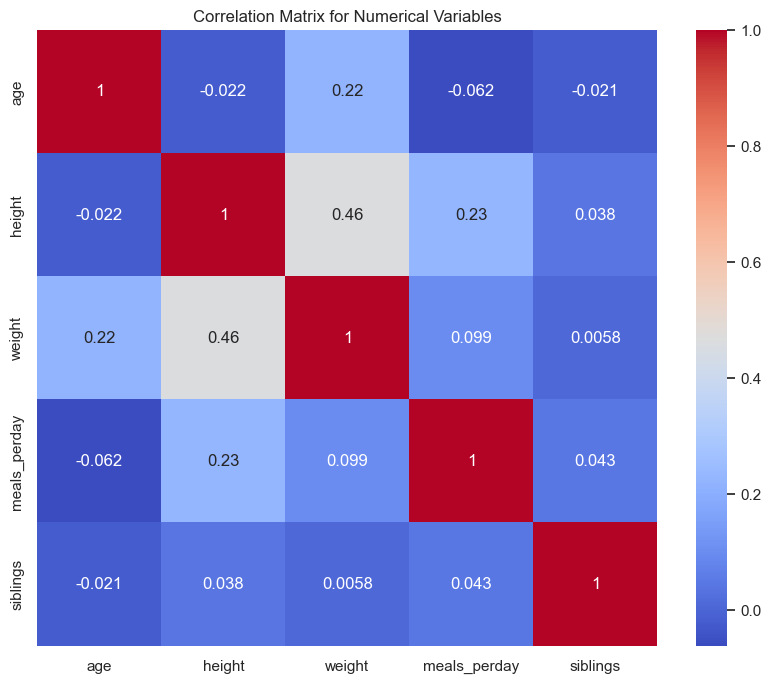

In [87]:
# Heatmap of correlation for numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(obesity_train_raw[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

In [88]:
def count_uniques(df):
    """
    Function to count unique values in each column of a DataFrame
    """
    unique_counts = df.nunique()
    unique_counts.columns = ['Column', 'Unique Values']
    return unique_counts

print(count_uniques(obesity_train_raw))


id                           1611
age                            39
alcohol_freq                    4
caloric_freq                    2
devices_perday                  3
eat_between_meals               4
gender                          2
height                         53
marrital_status                 0
meals_perday                    4
monitor_calories                2
parent_overweight               2
physical_activity_perweek       3
region                          1
siblings                        4
smoke                           2
transportation                  5
veggies_freq                    3
water_daily                     3
weight                        116
obese_level                     7
dtype: int64


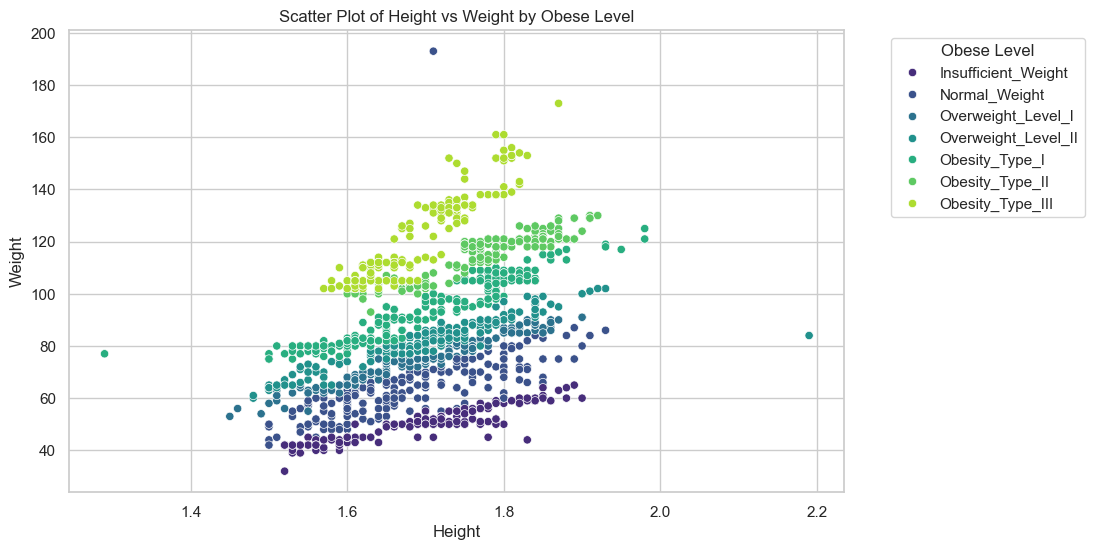

In [89]:
obesity_train_raw_EDA = obesity_train_raw.copy() # Preserve original dataframe

obesity_train_raw_EDA['obese_level'] = pd.Categorical(
    obesity_train_raw['obese_level'],
    categories=[
        'Insufficient_Weight',
        'Normal_Weight',
        'Overweight_Level_I',
        'Overweight_Level_II',
        'Obesity_Type_I',
        'Obesity_Type_II',
        'Obesity_Type_III'
    ],
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=obesity_train_raw_EDA, x='height', y='weight', hue='obese_level', palette='viridis')
plt.title('Scatter Plot of Height vs Weight by Obese Level')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

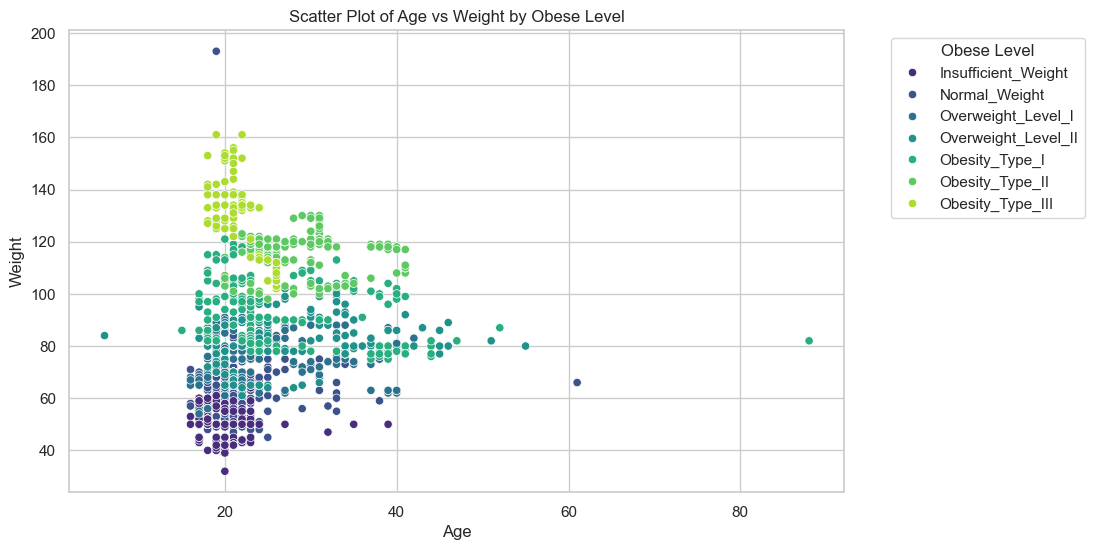

In [90]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=obesity_train_raw_EDA, x='age', y='weight', hue='obese_level', palette='viridis')
plt.title('Scatter Plot of Age vs Weight by Obese Level')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

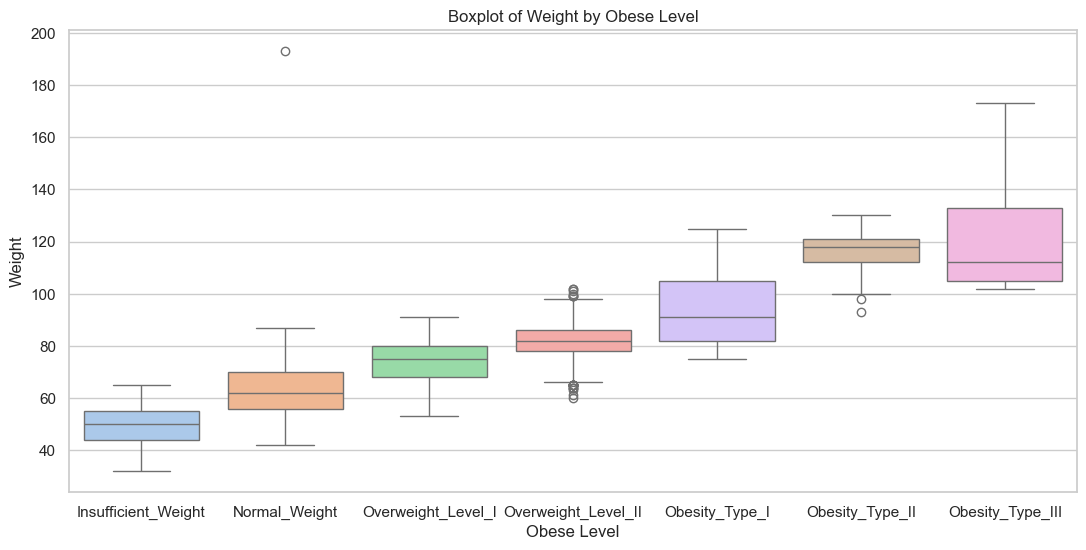

In [91]:
plt.figure(figsize=(13, 6))
sns.boxplot(data=obesity_train_raw_EDA, x='obese_level', y='weight', palette='pastel')
plt.title('Boxplot of Weight by Obese Level')
plt.xlabel('Obese Level')
plt.ylabel('Weight')
plt.show()

In [92]:
categorical_columns = obesity_train_raw.select_dtypes(include='object').columns
target_column = 'obese_level'
chi2_results = []
for col in categorical_columns:
    if col != target_column:
        contingency_table = pd.crosstab(obesity_train_raw[col], obesity_train_raw[target_column])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({'Variable': col, 'Chi2 Statistic': chi2, 'p-value': p})
chi2_results_df = pd.DataFrame(chi2_results)
chi2_results_df = chi2_results_df.sort_values(by='p-value') 
print(chi2_results_df)

                     Variable  Chi2 Statistic        p-value
3           eat_between_meals      602.723235  2.286336e-116
4                      gender      491.236927  6.490603e-103
6           parent_overweight      467.536896   8.239680e-98
11               veggies_freq      412.501632   8.507672e-81
0                alcohol_freq      246.495400   4.205366e-42
1                caloric_freq      182.130040   1.197222e-36
10             transportation      234.550350   1.864275e-36
2              devices_perday      144.649421   6.881412e-25
7   physical_activity_perweek      107.814257   1.617657e-17
12                water_daily       99.985735   5.603695e-16
5            monitor_calories       78.791072   6.348028e-15
9                       smoke       37.969702   1.138785e-06
8                      region        0.000000   1.000000e+00


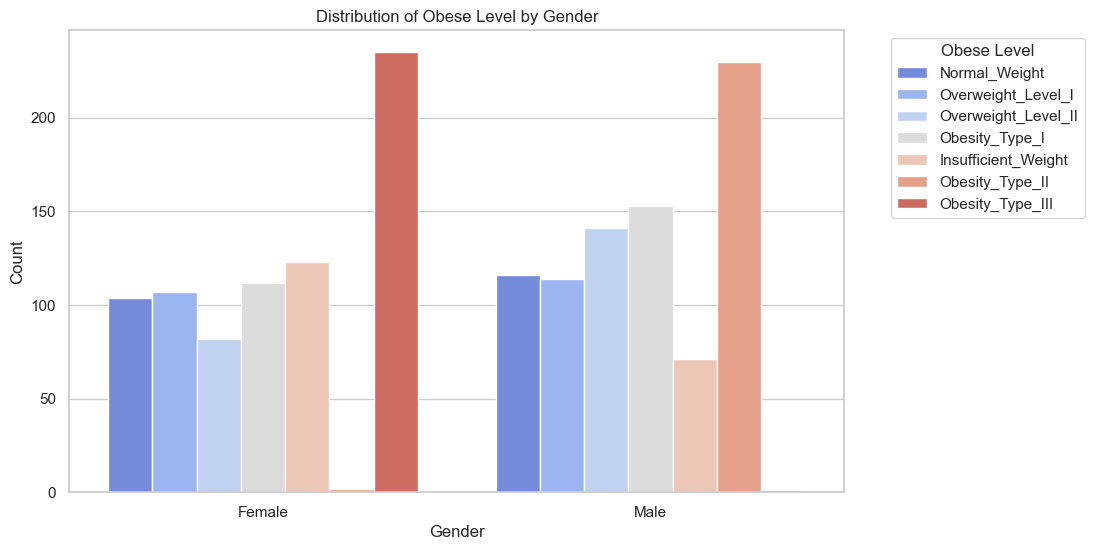

In [93]:
plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw, x='gender', hue='obese_level', palette='coolwarm')
plt.title('Distribution of Obese Level by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

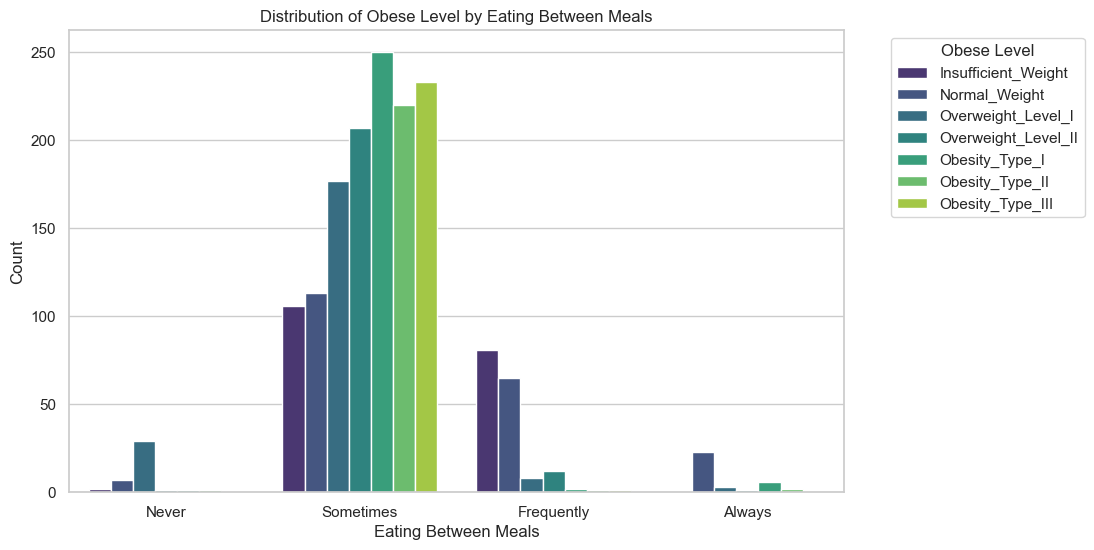

In [94]:
obesity_train_raw_EDA['eat_between_meals'] = pd.Categorical(
    obesity_train_raw['eat_between_meals'],
    categories=['Never', 'Sometimes', 'Frequently', 'Always'],
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw_EDA, x='eat_between_meals', hue='obese_level', palette='viridis')
plt.title('Distribution of Obese Level by Eating Between Meals')
plt.xlabel('Eating Between Meals')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

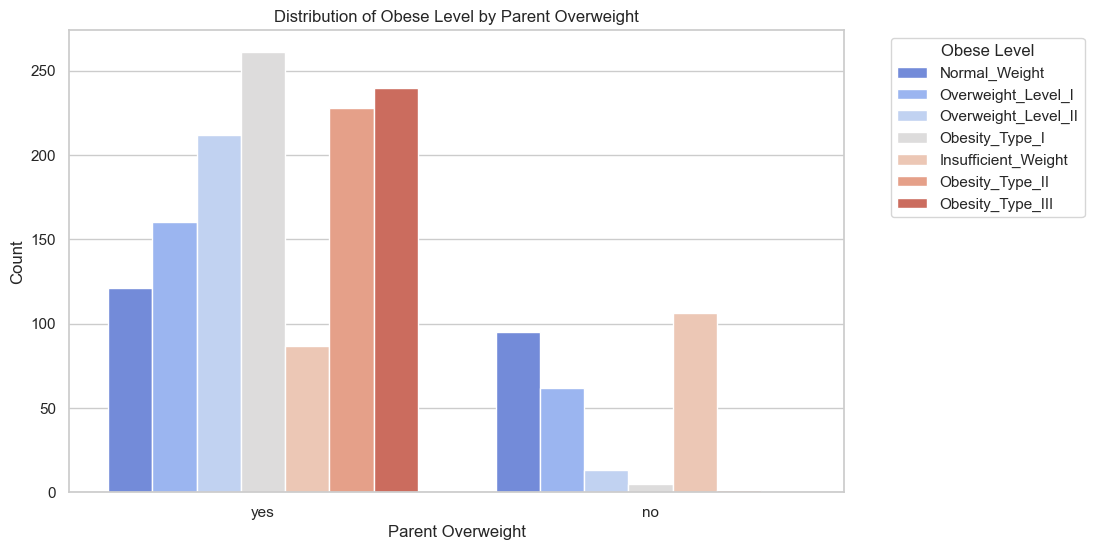

In [95]:
plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw, x='parent_overweight', hue='obese_level', palette='coolwarm')
plt.title('Distribution of Obese Level by Parent Overweight')
plt.xlabel('Parent Overweight')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

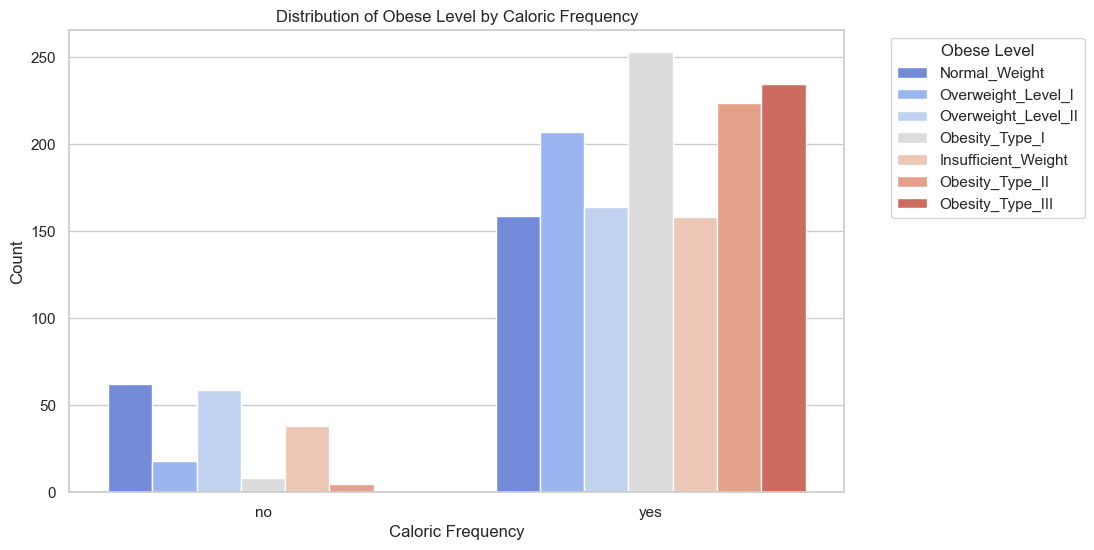

In [96]:
plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw, x='caloric_freq', hue='obese_level', palette='coolwarm')
plt.title('Distribution of Obese Level by Caloric Frequency')
plt.xlabel('Caloric Frequency')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


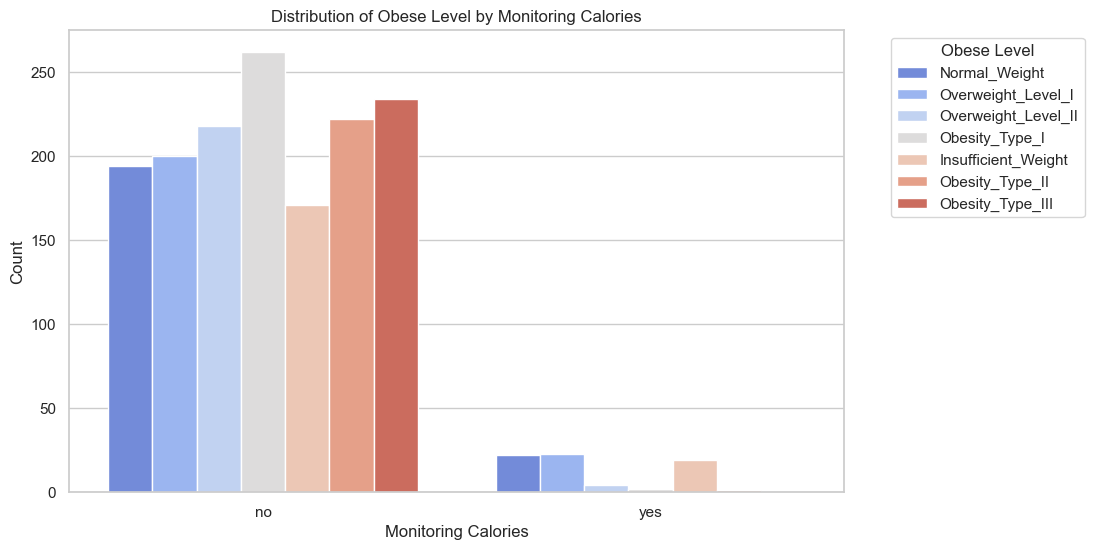

In [97]:
plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw, x='monitor_calories', hue='obese_level', palette='coolwarm')
plt.title('Distribution of Obese Level by Monitoring Calories')
plt.xlabel('Monitoring Calories')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

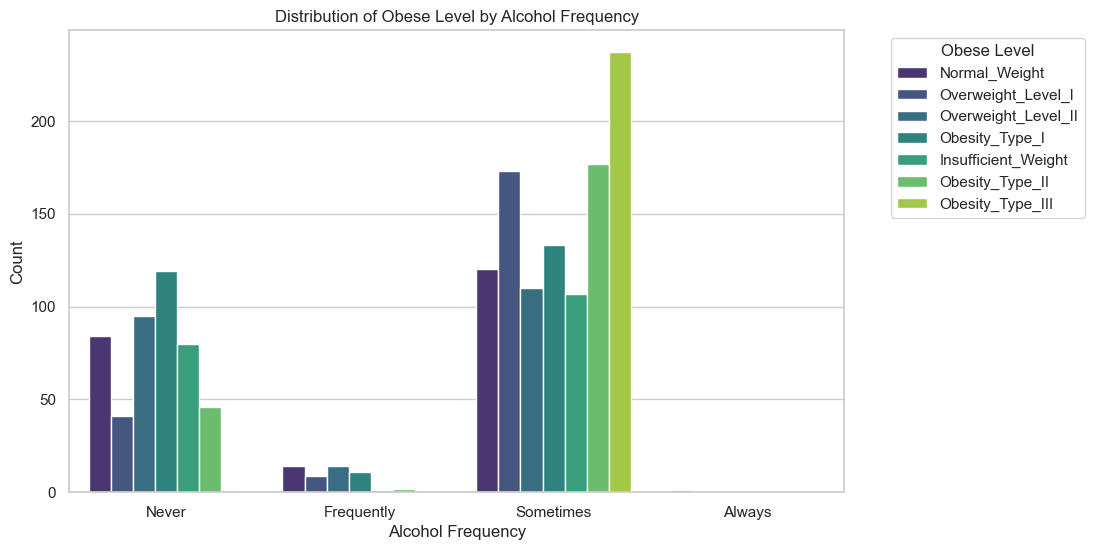

In [98]:
plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw, x='alcohol_freq', hue='obese_level', palette='viridis')
plt.title('Distribution of Obese Level by Alcohol Frequency')
plt.xlabel('Alcohol Frequency')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

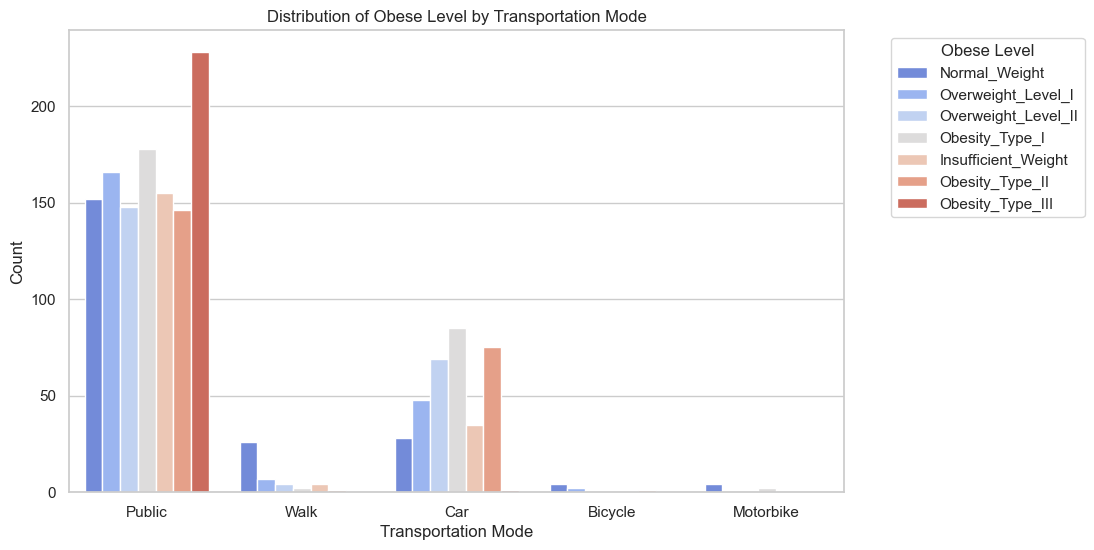

In [99]:
plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw, x='transportation', hue='obese_level', palette='coolwarm')
plt.title('Distribution of Obese Level by Transportation Mode')
plt.xlabel('Transportation Mode')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

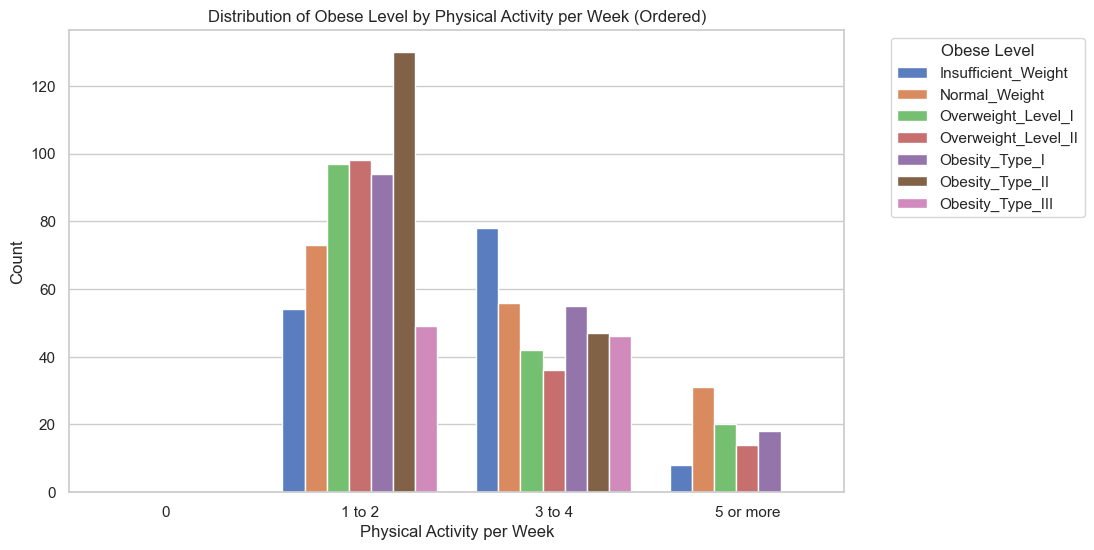

In [100]:
obesity_train_raw_EDA['physical_activity_perweek'] = pd.Categorical(
    obesity_train_raw_EDA['physical_activity_perweek'],
    categories=['0', '1 to 2', '3 to 4', '5 or more'],
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.countplot(data=obesity_train_raw_EDA, x='physical_activity_perweek', hue='obese_level', palette='muted')
plt.title('Distribution of Obese Level by Physical Activity per Week (Ordered)')
plt.xlabel('Physical Activity per Week')
plt.ylabel('Count')
plt.legend(title='Obese Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<a class="anchor" id="">

# 3. Data preparation

</a>

<img src="../image/step3.png" style="height:60px">

### 3.1. Removing unnecessary columns

In [101]:
# Drop the 'marrital_status' and 'region' columns from the dataset, 
# beacuse marrital status is empty and region has 1 unique value
obesity_train = obesity_train_raw.drop(columns=['marrital_status', 'region'])

In [102]:
obesity_train.set_index('id', inplace=True)

### 3.2. Outliers detection

In [103]:
#Detecting outliers in age, weight and height with IQR

def calculate_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

age_outliers = calculate_outliers_iqr(obesity_train, 'age')
weight_outliers = calculate_outliers_iqr(obesity_train, 'weight')
height_outliers = calculate_outliers_iqr(obesity_train, 'height')

print(f"Age outliers:{age_outliers}\n")
print(f"Weight outliers:{weight_outliers}\n")
print(f"Height outliers:{height_outliers}\n")


Age outliers:(11.0, 35.0)

Weight outliers:(7.0, 167.0)

Height outliers:(1.4199999999999997, 1.9800000000000002)



In [104]:
#Detecting outliers in age, weight, height with Z-score, using 3 standard deviations as the threshold

def calculate_outliers_zscore(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    return lower_bound, upper_bound

age_outliers_zscore = calculate_outliers_zscore(obesity_train, 'age')
weight_outliers_zscore = calculate_outliers_zscore(obesity_train, 'weight')
height_outliers_zscore = calculate_outliers_zscore(obesity_train, 'height')

print(f"Age outliers based on Z-score: {age_outliers_zscore}\n")
print(f"Weight outliers based on Z-score: {weight_outliers_zscore}\n")
print(f"Height outliers based on Z-score: {height_outliers_zscore}\n")

Age outliers based on Z-score: (4.9214904752265625, 43.76847716231389)

Weight outliers based on Z-score: (8.739336205795198, 165.17337239497505)

Height outliers based on Z-score: (1.4174056860550368, 1.9908097178272426)



In [105]:
# Detecting outliers in age, weight, height with KNN

data_to_check = obesity_train[['age', 'height', 'weight']].dropna()

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.05)

outlier_labels = lof.fit_predict(data_to_check)

outliers_knn = data_to_check[outlier_labels == -1]

print(outliers_knn)

       age  height  weight
id                        
10    27.0    1.93   102.0
246   23.0    1.72    76.0
283   19.0    1.80    60.0
316   33.0    1.83   113.0
375   19.0    1.80    60.0
...    ...     ...     ...
1578  22.0    1.72   132.0
1598  26.0    1.65   112.0
1602  26.0    1.61   105.0
1605  21.0    1.72   133.0
1607  21.0    1.73   131.0

[75 rows x 3 columns]


In [106]:
obesity_train.shape

(1611, 18)

In [107]:
# Removing outliers based on Z-score for age and weight and survey information
outliers = obesity_train[
    ((obesity_train['age'] < 16) & ~(obesity_train['age'].isna())) |
    (obesity_train['age'] > 56) | 
    ((obesity_train['weight'] > 165) & ~(obesity_train['weight'].isna()))|
    ((obesity_train['height'] > 1.99) & ~(obesity_train['height'].isna())) |
    (obesity_train['height'] < 1.41) 
]
obesity_train.drop(outliers.index, inplace=True)
obesity_train.reset_index(drop=True, inplace=True)

In [108]:
#Removed 7 rows
obesity_train.shape 

(1604, 18)

### 3.3 Encoding categorical data

In [109]:
#Divide columns into categorical/binary and numerical
categorical_columns = obesity_train.select_dtypes(include='object').columns.tolist()
numerical_columns = obesity_train.select_dtypes(exclude='object').columns.tolist()
categorical_columns

['alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'eat_between_meals',
 'gender',
 'monitor_calories',
 'parent_overweight',
 'physical_activity_perweek',
 'smoke',
 'transportation',
 'veggies_freq',
 'water_daily',
 'obese_level']

In [110]:
#Manually encode the categorical & binary columns
hashmap = {
"Never": 0,
"Sometimes": 1,
"Frequently": 2,
"Always": 3,

"No Activity": 0,
"up to 2": 1,
"up to 5": 2,
"more than 5": 3,

"less than 1": 1,
"1 to 2": 2,
"more than 2": 3,
"3 to 4": 4,
"5 or more": 5,

"Bicycle": 1,
"Car": 4,
"Motorbike": 3,
"Public": 2,
"Walk": 0,

"no": 0,
"yes": 1,

"Male": 0,
"Female": 1
}

In [111]:
# Manually encode data
for target in categorical_columns:
    obesity_train[target] = obesity_train[target].replace(hashmap)
    print(target, 'replaced')

# Manually encode the gender:
obesity_train['gender'] = obesity_train['gender'].replace(hashmap)

alcohol_freq replaced
caloric_freq replaced
devices_perday replaced
eat_between_meals replaced
gender replaced
monitor_calories replaced
parent_overweight replaced
physical_activity_perweek replaced
smoke replaced
transportation replaced
veggies_freq replaced
water_daily replaced
obese_level replaced


In [112]:
obesity_train_encoded = obesity_train.copy()
obesity_train_encoded.isna().sum()

age                           65
alcohol_freq                  36
caloric_freq                  20
devices_perday                21
eat_between_meals             59
gender                        20
height                        13
meals_perday                   9
monitor_calories              39
parent_overweight             20
physical_activity_perweek    563
siblings                      12
smoke                         12
transportation                40
veggies_freq                  26
water_daily                   34
weight                        53
obese_level                    0
dtype: int64

In [113]:
X = obesity_train_encoded.drop(columns='obese_level')
y = obesity_train_encoded[['obese_level']]

In [114]:
# Manually encode the target variable

hash_obesity = {
 'Normal_Weight': 1,
 'Overweight_Level_I': 2,
 'Overweight_Level_II': 3,
 'Obesity_Type_I': 4,
 'Insufficient_Weight': 5,
 'Obesity_Type_II': 6,
 'Obesity_Type_III': 7
 }

y = y['obese_level'].replace(hash_obesity)

In [115]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(zip(np.unique(y), class_weights))

In [116]:
class_weights_dict

{1: 1.0415584415584416,
 2: 1.0184126984126984,
 3: 1.0184126984126984,
 4: 0.8614393125671321,
 5: 1.1631617113850616,
 6: 0.9876847290640394,
 7: 0.958756724447101}

### 3.4 Handling Missing Values

In [117]:
# ASSUMPTION: There is no 0 value in the scope. We assume nulls are the people who dont work out
X['physical_activity_perweek'].fillna(0, inplace=True) 

In [118]:
X.isna().sum()

age                          65
alcohol_freq                 36
caloric_freq                 20
devices_perday               21
eat_between_meals            59
gender                       20
height                       13
meals_perday                  9
monitor_calories             39
parent_overweight            20
physical_activity_perweek     0
siblings                     12
smoke                        12
transportation               40
veggies_freq                 26
water_daily                  34
weight                       53
dtype: int64

#### Imputing missing numerical values with KNN

In [119]:
def knn_impute(X_train, X_val, numerical_columns, n_neighbors=5):

    # Create copies for KNN imputation
    data_knnimputer_train = X_train.copy()
    data_knnimputer_val = X_val.copy()

    # Specify the columns to scale
    numerical_columns_features = numerical_columns + ['gender']

    # Scale the data for KNN imputation
    scaler = StandardScaler()
    data_knnimputer_train[numerical_columns_features] = scaler.fit_transform(data_knnimputer_train[numerical_columns_features])
    data_knnimputer_val[numerical_columns_features] = scaler.transform(data_knnimputer_val[numerical_columns_features])

    # Perform KNN imputation
    knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights='uniform')
    data_knnimputer_train[numerical_columns_features] = knn_imputer.fit_transform(data_knnimputer_train[numerical_columns_features])
    data_knnimputer_val[numerical_columns_features] = knn_imputer.transform(data_knnimputer_val[numerical_columns_features])

    # Inverse transform to original scale
    data_knnimputer_train[numerical_columns_features] = scaler.inverse_transform(data_knnimputer_train[numerical_columns_features])
    data_knnimputer_val[numerical_columns_features] = scaler.inverse_transform(data_knnimputer_val[numerical_columns_features])

    return data_knnimputer_train, data_knnimputer_val

#### Imputing missing categorical values with Iterative Imputer

In [120]:
def iterative_impute(X_train, X_val, estimator=KNeighborsClassifier(n_neighbors=5), max_iter=10, random_state=42):
    """
    Perform iterative imputation on the training and validation datasets using a specified estimator.
    Parameters:
    X_train (pd.DataFrame): The training dataset with missing values.
    X_val (pd.DataFrame): The validation dataset with missing values.
    estimator (object, optional): The estimator to use for imputation. Default is KNeighborsClassifier with 5 neighbors.
    max_iter (int, optional): The maximum number of imputation iterations. Default is 10.
    random_state (int, optional): The random seed for reproducibility. Default is 42.
    Returns:
    tuple: A tuple containing the imputed training and validation datasets as pandas DataFrames.
    """

    iterative_imputer = IterativeImputer(estimator=estimator, max_iter=max_iter, random_state=random_state, 
                                         skip_complete=True)
    
    # Perform imputation on the training and validation data
    X_train_imputed = iterative_imputer.fit_transform(X_train)
    X_val_imputed = iterative_imputer.transform(X_val)
    
    # Convert back to DataFrame and assign original column names
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
    X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val.columns)
    
    return X_train_imputed, X_val_imputed

### 4. Feature engineering

In [121]:
!pip install pygrowup

In [122]:
from pygrowup import Calculator

def classify_bmi(df):
    """
    Classify BMI categories for children and adults using WHO standards.
    """
    # Calculate BMI
    bmi = df['weight'] / (df['height'] ** 2)
    
    # Initialize results
    classifications = pd.Series(index=df.index, dtype=int)
    
    # Masks
    children_mask = (df['age'] >= 2) & (df['age'] < 20)
    adult_mask = (df['age'] >= 20) & (df['age'] < 65)
    
    # Convert age and height for children
    df = df.copy()  # Create copy to avoid SettingWithCopyWarning
    df.loc[children_mask, 'age_months'] = df.loc[children_mask, 'age'] * 12
    df.loc[children_mask, 'height_cm'] = df.loc[children_mask, 'height'] * 100
    
    # Ensure gender is string type
    df['gender_str'] = df['gender'].map({0: 'M', 1: 'F'}).astype(str)
    
    # Initialize calculator
    calculator = Calculator(adjust_height_data=False, 
                          adjust_weight_scores=False, 
                          include_cdc=True)
    
    # Modified compute_bfa_zscore function
    def compute_bfa_zscore(row):
        try:
            score = calculator.zscore_for_measurement(
                measurement=float(row['weight'] / (row['height'] ** 2)),
                indicator='bmifa',
                age_in_months=float(row['age_months']),
                sex=str(row['gender_str']),  # Ensure string type
                height=float(row['height_cm'])
            )
            return score
        except (AssertionError, ValueError):
            return np.nan
    
    # Calculate z-scores for children
    df.loc[children_mask, 'bfa_zscore'] = df[children_mask].apply(compute_bfa_zscore, axis=1)
    
    # Classify children
    children_class = pd.Series(index=df.index, dtype=float)
    children_class[df['bfa_zscore'] < -2] = 0
    children_class[(df['bfa_zscore'] >= -2) & (df['bfa_zscore'] <= 1)] = 1
    children_class[(df['bfa_zscore'] > 1) & (df['bfa_zscore'] <= 2)] = 2
    children_class[df['bfa_zscore'] > 2] = 3
    
    # Classify adults
    adult_class = pd.Series(index=df.index, dtype=float)
    adult_class[bmi < 18.5] = 0
    adult_class[(bmi >= 18.5) & (bmi < 25)] = 1
    adult_class[(bmi >= 25) & (bmi < 30)] = 2
    adult_class[(bmi >= 30) & (bmi < 35)] = 3
    adult_class[(bmi >= 35) & (bmi < 40)] = 4
    adult_class[bmi >= 40] = 5
    
    # Combine classifications
    classifications[children_mask] = children_class[children_mask]
    classifications[adult_mask] = adult_class[adult_mask]
    
    return classifications.fillna(100).astype(int)  # Return -1 for invalid entries

In [123]:
def add_life_score(df):
    """
    Adds a 'life' score column to the given DataFrame by summing up the values of specific lifestyle-related columns.
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing lifestyle-related columns.
    Returns:
    pandas.DataFrame: The DataFrame with an additional 'life' score column.
    If any of these columns are not present in the DataFrame, they will be ignored in the calculation.
    """
    
    life_columns = [
        'alcohol_freq',
        'caloric_freq',
        'devices_perday',
        'eat_between_meals',
        'monitor_calories',
        'physical_activity_perweek',
        'smoke',
        'transportation',
        'veggies_freq',
        'water_daily'
    ]

    df["life"] = 0
    for column in life_columns:
        if column in df.columns:
            df["life"] += df[column]
    return df

# 5. Feature Selection

### Feature importances using Gradient Boosted Tree Classifier

In [124]:
# Initialize the Decision Tree model
tree = RandomForestClassifier(random_state=42)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform Stratified K-Fold Cross Validation
f1_scores = []

for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # Impute missing values using KNN impute
    X_train_fold, X_val_fold = knn_impute(X_train_fold, X_val_fold, numerical_columns)

    # Round the gender
    X_train_fold['gender']= X_train_fold['gender'].apply(lambda x: round(x))
    X_val_fold['gender']= X_val_fold['gender'].apply(lambda x: round(x))

    # Classify BMI based on age and BMI value
    X_train_fold['bmi_class'] = classify_bmi(X_train_fold)
    X_val_fold['bmi_class'] = classify_bmi(X_val_fold)

    # Impute missing values using Iterative impute
    X_train_fold, X_val_fold = iterative_impute(X_train_fold, X_val_fold)

    # Add life feature
    add_life_score(X_train_fold)
    add_life_score(X_val_fold)
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Fit the scaler on the training fold and transform both training and validation folds
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Fit the model on the training fold
    tree.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_fold = tree.predict(X_val_fold)
    
    # Calculate F1 score
    f1 = f1_score(y_val_fold, y_pred_fold, average='macro')
    f1_scores.append(f1)

# Print the average F1 score
print(f"Average F1 Score: {np.mean(f1_scores)}")

Average F1 Score: 0.9511606681706226


In [125]:
all_columns = X.columns.tolist() + ['bmi_class', 'life']

In [126]:
# Display feature importances using Gradient Boosting Classifier
importances = tree.feature_importances_

importances_df = pd.DataFrame(importances, index=all_columns, columns=['importance'])
importances_df = importances_df.sort_values('importance', ascending=False)
importances_df.style.bar()

,importance
bmi_class,0.263641
weight,0.236519
height,0.077153
age,0.074317
gender,0.065183
meals_perday,0.032366
veggies_freq,0.031824
life,0.029981
parent_overweight,0.027080
eat_between_meals,0.026111


We see that weight, bmi_class, gender, age and height hold significant importance and should be included in the model

**Numerical values variance**

In [127]:
numerical_columns

['age', 'height', 'meals_perday', 'siblings', 'weight']

In [128]:
variance_df = X.copy()
variance_df['heigh_cm'] = variance_df['height'] * 100
var_columns  =  ['age', 'weight', 'heigh_cm', 'height']
for column in var_columns:
    print(f"{column} has variance of {variance_df[column].var()}")


age has variance of 38.13784473223687
weight has variance of 670.4263189201561
heigh_cm has variance of 88.87618403836065
height has variance of 0.008887618403835998


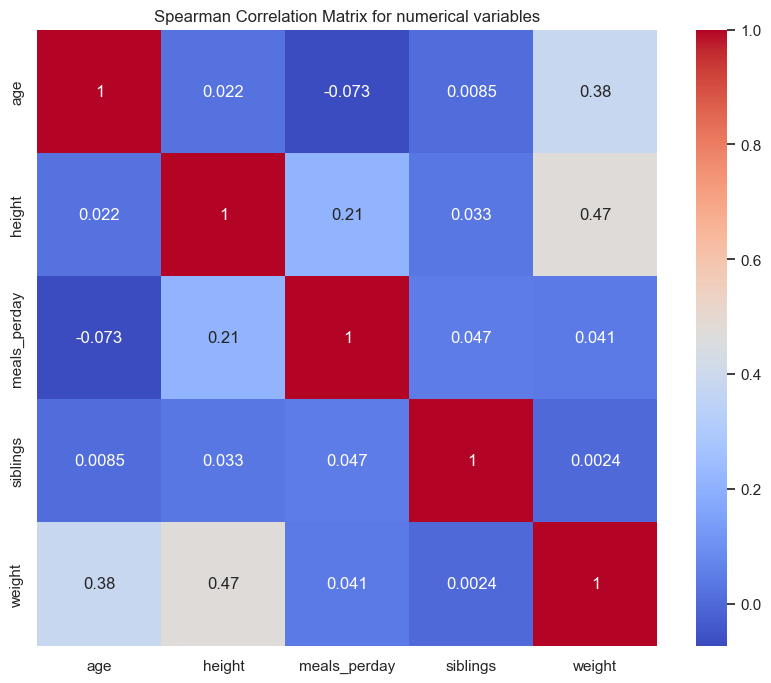

In [129]:
# Heatmap of correlation for numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_columns].corr('spearman'), annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix for numerical variables')
plt.show()

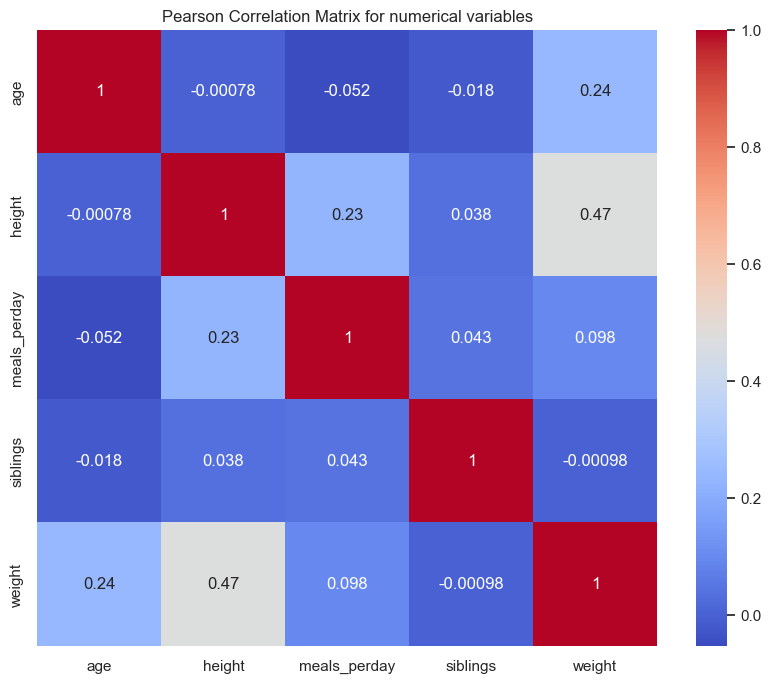

In [130]:
# Heatmap of correlation for numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix for numerical variables')
plt.show()

In [131]:
categorical_columns = list(filter(lambda x: x != 'obese_level', categorical_columns))
categorical_columns

['alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'eat_between_meals',
 'gender',
 'monitor_calories',
 'parent_overweight',
 'physical_activity_perweek',
 'smoke',
 'transportation',
 'veggies_freq',
 'water_daily']

In [132]:
import scipy.stats as stats

def TestIndependence(X,y,column,alpha=0.05):        
    df = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(df.values)
    dfExpected = pd.DataFrame(expected, columns=df.columns, index = df.index)
    if p<alpha:
        result=f"{column} is IMPORTANT for Prediction"
    else:
        result=f"{column} is NOT an important predictor"
    print(result)

for column in categorical_columns:
    TestIndependence(X[var],y, column)

alcohol_freq is IMPORTANT for Prediction
caloric_freq is IMPORTANT for Prediction
devices_perday is IMPORTANT for Prediction
eat_between_meals is IMPORTANT for Prediction
gender is IMPORTANT for Prediction
monitor_calories is IMPORTANT for Prediction
parent_overweight is IMPORTANT for Prediction
physical_activity_perweek is IMPORTANT for Prediction
smoke is IMPORTANT for Prediction
transportation is IMPORTANT for Prediction
veggies_freq is IMPORTANT for Prediction
water_daily is IMPORTANT for Prediction


### Feature selection using RFE

This script performs feature selection using Recursive Feature Elimination (RFE) with cross-validation to determine the optimal number of features for a RandomForestClassifier model. 
The process includes the following steps:
1. Define the range of number of features to select.
2. Initialize variables to track the highest F1 score and corresponding number of features.
3. Perform Stratified K-Fold cross-validation to ensure balanced class distribution in each fold.
4. For each fold:
    a. Split the training data into training and validation sets.
    b. Impute missing values using KNN imputation for numerical columns.
    c. Classify BMI based on age and BMI value.
    d. Impute missing values using Iterative imputation.
    e. Add a life score feature to the dataset.
    f. Scale the data using StandardScaler.
    g. Perform feature selection using RFE with a RandomForestClassifier.
    h. Train the model on the selected features and evaluate using F1 score.
5. Track the average F1 score for each number of features.
Identify the number of features that yields the highest F1 score.
7. Print the optimal number of features and the corresponding highest F1 score.

In [133]:
# start from 5 because weight, bmi, gender, age and height will definitely be inside the model based on feature importances
nof_list = np.arange(5, len(all_columns) + 1) 
high_score = float('-inf')
nof = 0
score_list = []
best_features = None

skf = StratifiedKFold(n_splits=10, shuffle=True)

for n in tqdm(nof_list):
    fold_scores = []
    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Impute missing values using KNN impute
        X_train_fold, X_val_fold = knn_impute(X_train_fold, X_val_fold, numerical_columns)

        # Round the gender
        X_train_fold['gender']= X_train_fold['gender'].apply(lambda x: round(x))
        X_val_fold['gender']= X_val_fold['gender'].apply(lambda x: round(x))

        # Classify BMI based on age and BMI value
        X_train_fold['bmi_class'] = classify_bmi(X_train_fold)
        X_val_fold['bmi_class'] = classify_bmi(X_val_fold)
        
        # Impute missing values using Iterative impute
        X_train_fold, X_val_fold = iterative_impute(X_train_fold, X_val_fold)

        # Add life feature
        add_life_score(X_train_fold)
        add_life_score(X_val_fold)

        # Scale the data
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        
        # Feature selection using RFE
        model = RandomForestClassifier(random_state=42)
        rfe = RFE(model, n_features_to_select=n)
        X_train_rfe = rfe.fit_transform(X_train_fold, y_train_fold)
        X_val_rfe = rfe.transform(X_val_fold)

        # Train and evaluate the model
        model.fit(X_train_rfe, y_train_fold)
        y_pred = model.predict(X_val_rfe)
        score = f1_score(y_val_fold, y_pred, average='macro')
        fold_scores.append(score)
    
    avg_score = np.mean(fold_scores)
    score_list.append(avg_score)
    
    if avg_score > high_score:
        high_score = avg_score
        nof = n
        best_features = rfe.get_support()

print(f"Optimum number of features: {nof}")
print(f"Highest F1 score with {nof} features: {high_score:.6f}")


  0%|          | 0/15 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [134]:
# Filter `new_columns` with the boolean mask to get selected feature names
selected_feature_names = np.array(all_columns)[best_features]
print(f"Selected {nof} features:")
print(selected_feature_names)

Selected 0 features:
[['age' 'alcohol_freq' 'caloric_freq' 'devices_perday'
  'eat_between_meals' 'gender' 'height' 'meals_perday' 'monitor_calories'
  'parent_overweight' 'physical_activity_perweek' 'siblings' 'smoke'
  'transportation' 'veggies_freq' 'water_daily' 'weight' 'bmi_class'
  'life']]


In [135]:
selected_feature_names = ['age', 'alcohol_freq', 'devices_perday', 'eat_between_meals', 'gender',
 'height', 'meals_perday', 'parent_overweight', 'physical_activity_perweek',
 'veggies_freq', 'water_daily', 'weight', 'bmi_class', 'life']

In [136]:
# it tells us to keep newly added columns like 'bmi_class' and 'life'
# We delete 'smoke' and 'siblings'
# Probably also caloric_frequency, monitor_calories, water_daily


# Filter out 'bmi_class' and 'life' from selected_feature_names
filtered_selected_features = [feature for feature in selected_feature_names if feature not in ['bmi_class', 'life']]

numerical_columns = [feature for feature in numerical_columns if feature in selected_feature_names]

# Create a DataFrame with only the filtered selected features
X_selected = X[filtered_selected_features]
X_selected.head(3)

,age,alcohol_freq,devices_perday,eat_between_meals,gender,height,meals_perday,parent_overweight,physical_activity_perweek,veggies_freq,water_daily,weight
0,21.0,0.0,2.0,1.0,1.0,1.62,3.0,1.0,0.0,1.0,2.0,64.0
1,23.0,2.0,2.0,1.0,0.0,1.80,3.0,1.0,4.0,1.0,2.0,77.0
2,NaN,2.0,1.0,1.0,0.0,1.80,3.0,0.0,4.0,3.0,2.0,87.0


<a class="anchor" id="">

# 6. Modelling and Assessment

</a>

### 6.1. Model Selection

In this section you should take the time to train different predictive algorithms with the data that got to this stage and **use the approppriate model assessment metrics to decide which model you think is the best to address your problem**.

**You are expected to present on your report the model performances of the different algorithms that you tested and discuss what informed your choice for a specific algorithm**

In [137]:
def run_model(model, X, y):
    """
    Runs and evaluates a model according to the finalized pipeline.
        model: an instance of a model implemented in Sklearn, such as DecisionTreeClassifier()
        X, y: Dataset
    """
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    train_f1 = []
    val_f1 = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Impute missing values using KNN impute
        X_train_fold, X_val_fold = knn_impute(X_train_fold, X_val_fold, numerical_columns)

        # Round the gender
        X_train_fold['gender']= X_train_fold['gender'].apply(lambda x: round(x))
        X_val_fold['gender']= X_val_fold['gender'].apply(lambda x: round(x))

        # Classify BMI based on age and BMI value
        X_train_fold['bmi_class'] = classify_bmi(X_train_fold)
        X_val_fold['bmi_class'] = classify_bmi(X_val_fold)

        # Impute missing values using Iterative impute
        X_train_fold, X_val_fold = iterative_impute(X_train_fold, X_val_fold)

        # Add life feature
        add_life_score(X_train_fold)
        add_life_score(X_val_fold)
        
        # Fit the model on the training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_val = model.predict(X_val_fold)
        y_pred_train = model.predict(X_train_fold)
        
        # Calculate F1 score of train and validation
        f1_train = f1_score(y_pred_train, y_pred_train, average='macro')
        f1_val = f1_score(y_val_fold, y_pred_val, average='macro')
        
        train_f1.append(f1_train)
        val_f1.append(f1_val)
    
    return(f"AVERAGE F1 SCORES\n\t- TRAIN:  {np.mean(train_f1)}\n\t- VALIDATION: {np.mean(val_f1)}")


In [138]:
MLP_PARAMS = {
    "hidden_layer_sizes":(300, 100, 50), 
    "activation":'relu',
    "learning_rate":'adaptive',
    "shuffle":True,
    "early_stopping":True,
    "alpha":0.001, # regularization parameter
    "validation_fraction":0.2,
    "random_state":42,
    #verbose=True, # True to see what happening inside. Only for training purposes
    "max_iter":1000
    } # Define paramers for MLP

# Define models to run & evaluate
models = [DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), BaggingClassifier(random_state=42), GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), MLPClassifier(**MLP_PARAMS)]

# Run each model
for model in models:
    print('\033[01m\033[95mEVALUATING MODEL', str(model), '\033[0m')
    print(run_model(model, X, y))
    print()
    print('\033[31m=======================X=====================\033[0m')
    print()

EVALUATING MODEL DecisionTreeClassifier(random_state=42) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.9087161088959874

=======================X=====================

EVALUATING MODEL RandomForestClassifier(random_state=42) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.9535475858515451

=======================X=====================

EVALUATING MODEL BaggingClassifier(random_state=42) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.9394049622928146

=======================X=====================

EVALUATING MODEL GradientBoostingClassifier(random_state=42) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.9535044540029783

=======================X=====================

EVALUATING MODEL AdaBoostClassifier(random_state=42) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.39330338296499023

=======================X=====================

EVALUATING MODEL MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(300, 100, 50), learning_rate='adaptive',

**RESULT**: Every model has a perfect train socre (expected as we're mostly using decision-tree based models), with GradientBoostingClassifier being the superior one with validation score $\approx 0.94055$

### 6.2. Model Optimization

After selecting the best algorithm (set of algorithms), you can try to optimize the performance of your model by fiddling with the algorithms' hyper-parameters and select the options that result on the best overall performance.

Possible ways of doing this can be through:
1. [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
2. [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

**While you are not required to show the results of all combinations of hyperparameters that you tried, you should at least discuss the what were the possible combinations used and which of them resulted in your best performance**

In [139]:
X_gridsearch = X.copy()
y_gridsearch = y.copy()

In [140]:
# Impute missing values using KNN impute
X_gridsearch, _ = knn_impute(X_gridsearch, X_gridsearch, numerical_columns)

# Impute missing values using Iterative impute
X_gridsearch, _ = iterative_impute(X_gridsearch, X_gridsearch)

# Classify BMI based on age and BMI value
X_gridsearch['bmi_class'] = classify_bmi(X_gridsearch)

# Add life feature
add_life_score(X_gridsearch)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training fold and transform both training and validation folds
X_gridsearch = scaler.fit_transform(X_gridsearch)

In [ ]:
# RandomSearchCV
"""
from sklearn.model_selection import RandomizedSearchCV

gbc = GradientBoostingClassifier()
domain = [{
    'n_estimators': np.arange(50, 500, 1),
    'max_depth': np.arange(3, 30, 1),
    'learning_rate': stats.loguniform(1e-3, 1),
    'min_samples_split': np.arange(2, 25, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'subsample': stats.loguniform(0.5, 1),
}]

gs = RandomizedSearchCV(gbc, domain,verbose=2, n_iter=1000)
gs.fit(X_gridsearch, y_gridsearch)
print(gs.best_params)
"""

In [141]:
rgs_param = {'n_estimators': 488, 
             'max_depth': 4, 
             'learning_rate': 0.1594940315048179345, 
             'min_samples_split': 2, 
             'min_samples_leaf': 4, 
             'subsample': 0.7184885508506397
}

In [429]:
# HalvingRandomSearch
"""
gbc = GradientBoostingClassifier(random_state=42)
domain = [{
    'n_estimators': np.arange(50, 500, 1),
    'max_depth': np.arange(3, 30, 1),
    'learning_rate': stats.loguniform(1e-3, 1),
    'min_samples_split': np.arange(2, 25, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'subsample': stats.loguniform(0.5, 1),
}]

hvrs = HalvingRandomSearchCV(gbc, domain,verbose=2, n_jobs=-1, factor=2,  random_state=42, n_candidates=500)

hvrs.fit(X_gridsearch, y_gridsearch)
hvrs.best_params_
"""

n_iterations: 5
n_required_iterations: 9
n_possible_iterations: 5
min_resources_: 70
max_resources_: 1604
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 500
n_resources: 70
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 250
n_resources: 140
Fitting 5 folds for each of 250 candidates, totalling 1250 fits
----------
iter: 2
n_candidates: 125
n_resources: 280
Fitting 5 folds for each of 125 candidates, totalling 625 fits
----------
iter: 3
n_candidates: 63
n_resources: 560
Fitting 5 folds for each of 63 candidates, totalling 315 fits
----------
iter: 4
n_candidates: 32
n_resources: 1120
Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'learning_rate': 0.4289262127724572,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 244,
 'subsample': 0.9697276317115711}

In [142]:
hvrs_params =  {'learning_rate': 0.4289262127724572,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 244,
 'subsample': 0.9697276317115711}


In [432]:
""" Code to generate results of HVRS search
results = pd.DataFrame(hvrs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6, figsize=(9,7))

labels = [
    f"iter={i}\nn_samples={hvrs.n_resources_[i]}\nn_candidates={hvrs.n_candidates_[i]}"
    for i in range(hvrs.n_iterations_)
]

ax.set_xticks(range(hvrs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()
"""

' Code to generate results of HVRS search\nresults = pd.DataFrame(hvrs.cv_results_)\nresults["params_str"] = results.params.apply(str)\nresults.drop_duplicates(subset=("params_str", "iter"), inplace=True)\nmean_scores = results.pivot(\n    index="iter", columns="params_str", values="mean_test_score"\n)\nax = mean_scores.plot(legend=False, alpha=0.6, figsize=(9,7))\n\nlabels = [\n    f"iter={i}\nn_samples={hvrs.n_resources_[i]}\nn_candidates={hvrs.n_candidates_[i]}"\n    for i in range(hvrs.n_iterations_)\n]\n\nax.set_xticks(range(hvrs.n_iterations_))\nax.set_xticklabels(labels, rotation=45, multialignment="left")\nax.set_title("Scores of candidates over iterations")\nax.set_ylabel("mean test score", fontsize=15)\nax.set_xlabel("iterations", fontsize=15)\nplt.tight_layout()\nplt.show()\n'

Here is an image of HalvedRandomSearch result:

![alt](../image/hvrs_results.png)

<img src="../image/step4.png" style="height:60px">

<a class="anchor" id="">

# 7. Deployment

</a>

<img src="../image/step5.png" style="height:60px">

### 7.1 Training a final model

You used the previous steps of modelling and assessment to determine what would be best strategies when it comes to preprocessing, scaling, feature selection, algorithm and hyper-parameters you could find.

**By this stage, all of those choices were already made**. For that reason, a split between training and validation is no longer necessary. **A good practice** would be to take the initial data and train a final model with all of the labeled data that you have available.

**Everything is figured by this stage**, so, on a first level all you need to do is replicate the exact preprocessing, scaling and feature selection decisions you made before.<br>
When it comes to the final model, all you have to do is creeate a new instance of your best algorithm with the best parameters that you uncovered (no need to try all algorithms and hyper-parameters again).

In [143]:
models = [GradientBoostingClassifier(**rgs_param), GradientBoostingClassifier(**hvrs_params)]

for model in models:
    print('\033[01m\033[95mEVALUATING MODEL', str(model), '\033[0m')
    print(run_model(model, X, y))
    print()
    print('\033[31m=======================X=====================\033[0m')
    print()

EVALUATING MODEL GradientBoostingClassifier(learning_rate=0.15949403150481795, max_depth=4,
                           min_samples_leaf=4, n_estimators=488,
                           subsample=0.7184885508506397) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.9558370794891532

=======================X=====================

EVALUATING MODEL GradientBoostingClassifier(learning_rate=0.4289262127724572, max_depth=5,
                           min_samples_leaf=3, min_samples_split=10,
                           n_estimators=244, subsample=0.9697276317115711) 
AVERAGE F1 SCORES
	- TRAIN:  1.0
	- VALIDATION: 0.9527727332244302

=======================X=====================



Decided to use results from randomized search as it yielded better results

In [435]:
# Initialize the Gradient Boosting model
tree_gb = GradientBoostingClassifier(**rgs_param)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform Stratified K-Fold Cross Validation
f1_scores = []
class_f1_scores = []

for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # Impute missing values using KNN impute
    X_train_fold, X_val_fold = knn_impute(X_train_fold, X_val_fold, numerical_columns)

    # Impute missing values using Iterative impute
    X_train_fold, X_val_fold = iterative_impute(X_train_fold, X_val_fold)

    # Only use selected features
    X_train_fold = X_train_fold[filtered_selected_features]
    X_val_fold = X_val_fold[filtered_selected_features]
    
    # Classify BMI based on age and BMI value
    X_train_fold['bmi_class'] = classify_bmi(X_train_fold)
    X_val_fold['bmi_class'] = classify_bmi(X_val_fold)

    # Add life feature
    add_life_score(X_train_fold)
    add_life_score(X_val_fold)
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Fit the model on the training fold
    tree_gb.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_fold = tree_gb.predict(X_val_fold)
    
    # Calculate F1 score
    f1 = f1_score(y_val_fold, y_pred_fold, average='macro')
    f1_scores.append(f1)
    
    # Calculate F1 score for each class
    report = classification_report(y_val_fold, y_pred_fold, output_dict=True)
    class_f1_scores.append({k: v['f1-score'] for k, v in report.items() if k.isdigit()})

# Print the average F1 score
print(f"Average F1 Score: {np.mean(f1_scores)}\n")

# Print the F1 score for each class
print("F1 Score for each class:")
for i, class_scores in enumerate(class_f1_scores):
    print(f"Fold {i+1}: {class_scores}")

Average F1 Score: 0.9518582284225816

F1 Score for each class:
Fold 1: {'1': 0.8636363636363636, '2': 0.9777777777777777, '3': 0.9777777777777777, '4': 0.9818181818181818, '5': 0.9230769230769231, '6': 1.0, '7': 1.0}
Fold 2: {'1': 0.8888888888888888, '2': 0.8979591836734694, '3': 0.9302325581395349, '4': 0.9433962264150944, '5': 0.918918918918919, '6': 0.9787234042553191, '7': 1.0}
Fold 3: {'1': 0.9523809523809523, '2': 0.8837209302325582, '3': 0.9166666666666666, '4': 0.9642857142857143, '5': 0.9743589743589743, '6': 1.0, '7': 1.0}
Fold 4: {'1': 0.8888888888888888, '2': 0.9333333333333333, '3': 0.9545454545454546, '4': 0.9285714285714286, '5': 0.9743589743589743, '6': 0.9787234042553191, '7': 0.9565217391304348}
Fold 5: {'1': 0.8837209302325582, '2': 0.8936170212765957, '3': 0.9090909090909091, '4': 0.9818181818181818, '5': 0.918918918918919, '6': 1.0, '7': 1.0}
Fold 6: {'1': 0.9090909090909091, '2': 0.9523809523809523, '3': 0.9583333333333334, '4': 0.9818181818181818, '5': 1.0, '6': 

In [ ]:
print(f1_scores)

[0.9672992382294707, 0.9368741686130323, 0.9624024923028245, 0.9511967952168824, 0.941023708762452, 0.968485879200165, 0.9866688866688866, 0.9341649565228458, 0.9470632387653931, 0.9372352234054363]


### 7.2 Import and Transform your test data

Remember, the test data does not have the `outcome` variable.

In [436]:
X_train = X.copy()
y_train = y.copy()

In [437]:
# Load testing data
X_test = pd.read_csv("../data/obesity_test.csv", index_col='id')

In [438]:
# Manually encode data

columns = ['alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'eat_between_meals',
 'gender',
 'monitor_calories',
 'parent_overweight',
 'physical_activity_perweek',
 'smoke',
 'transportation',
 'veggies_freq',
 'water_daily',
 'meals_perday',
 "siblings"]

for target in columns:
    X_test[target] = X_test[target].replace(hashmap)

In [439]:
X_test = X_test.drop(columns=['marrital_status', 'region'])

In [440]:
ids = X_test.index

In [441]:
tree_gb = GradientBoostingClassifier(**rgs_param)

In [442]:
# Impute missing values using KNN impute

# ASSUMPTION: There is no 0 value in the scope. We assume nulls are the people who dont work out
X_train['physical_activity_perweek'].fillna(0, inplace=True) 
X_test['physical_activity_perweek'].fillna(0, inplace=True)

X_train, X_test = knn_impute(X_train, X_test, numerical_columns)

# Impute missing values using Iterative impute
X_train, X_test = iterative_impute(X_train, X_test)

# Classify BMI based on age and BMI value
X_train['bmi_class'] = classify_bmi(X_train)
X_test['bmi_class'] = classify_bmi(X_test)

# Add life feature
add_life_score(X_train)
add_life_score(X_test)


,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,meals_perday,monitor_calories,parent_overweight,physical_activity_perweek,siblings,smoke,transportation,veggies_freq,water_daily,weight,bmi_class,life
0,21.0,1.0,0.0,1.0,1.0,1.0,1.52,3.0,1.0,1.0,5.0,3.0,1.0,2.0,3.0,3.0,56.0,1.0,18.0
1,29.0,1.0,1.0,1.0,1.0,0.0,1.62,3.0,0.0,0.0,0.0,3.0,0.0,4.0,1.0,2.0,53.0,1.0,11.0
2,23.0,1.0,1.0,1.0,1.0,1.0,1.50,3.0,0.0,1.0,2.0,2.0,0.0,3.0,3.0,2.0,65.8,2.0,14.0
3,22.0,0.0,1.0,2.0,1.0,0.0,1.72,3.0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,2.0,68.0,1.0,11.0
4,26.0,1.0,1.0,3.0,2.0,0.0,1.85,3.0,0.0,1.0,4.0,1.0,0.0,2.0,3.0,3.0,105.0,3.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,26.0,1.0,1.0,1.0,1.0,1.0,1.63,3.0,0.0,1.0,0.0,3.0,0.0,2.0,3.0,3.0,111.0,5.0,12.0
496,26.0,1.0,1.0,2.0,1.0,1.0,1.62,3.0,0.0,1.0,0.0,3.0,0.0,2.0,3.0,2.0,105.0,5.0,12.0
497,26.0,1.0,1.0,1.0,1.0,1.0,1.63,3.0,0.0,1.0,0.0,1.0,0.0,2.0,3.0,2.0,108.0,5.0,11.0
498,26.0,1.0,1.0,1.0,1.0,1.0,1.63,3.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,3.0,107.0,5.0,12.0


### 7.3 Obtain Predictions on the test data from your final model

In [443]:
# Fit the model on the training set
tree_gb.fit(X_train, y_train)

# Predict on the validation fold
predictions = tree_gb.predict(X_test)

In [444]:
# Invert to categories
hash_obesity_inverted = {
 1: 'Normal_Weight',
 2: 'Overweight_Level_I',
 3:'Overweight_Level_II',
 4:'Obesity_Type_I',
 5:'Insufficient_Weight',
 6:'Obesity_Type_II',
 7:'Obesity_Type_III'
 }

predictions = np.array([hash_obesity_inverted[pred] for pred in predictions])

### 7.4. Save predictions to csv

In [445]:
predictions_df = pd.DataFrame({'id': ids, 'predictions': predictions})

In [446]:
predictions_df

,id,predictions
0,1612,Normal_Weight
1,1613,Normal_Weight
2,1614,Overweight_Level_I
3,1615,Normal_Weight
4,1616,Obesity_Type_I
...,...,...
495,2107,Obesity_Type_III
496,2108,Obesity_Type_III
497,2109,Obesity_Type_III
498,2110,Obesity_Type_III


In [447]:
predictions_df.to_csv("../submission_FINAL.csv", index = False)

Submit the csv file to Kaggle to obtain the model performance of your model on the test data.

# 8. Extra
This part contains some optional parts, which could reveal useful for modelling purposes but are deemed either impractical or irrelevant to our study.


## 8.1. EXhaustive search try

In [ ]:
#!pip install mlxtend

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Set up the exhaustive feature selector, where 'other_features' will vary while 'must_have_features' remain
efs = ExhaustiveFeatureSelector(
    estimator=model,
    min_features=6,  # Start with at least 6 features
    max_features=len(X_train.columns),  # Consider up to all features
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1  # Use all available CPU cores
)

# Combine the must-have features with other features and scale them in each fold to avoid leakage
# Track progress with tqdm
with tqdm(total=len(X_train.columns)) as progress_bar:
    # Fit the feature selector on the dataset that includes both must-have and other features
    efs = efs.fit(X_train, y_train)
    progress_bar.update(len(X_train.columns))

# Get the best feature subset found by the selector, which includes combinations of other features and must-have features
selected_features = list(efs.best_feature_names_)

# Perform cross-validation on the final selected features with scaling in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []

for train_index, val_index in skf.split(X_train[final_features], y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index][final_features], X_train.iloc[val_index][final_features]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Initialize and fit the scaler only on the training data within each fold to avoid leakage
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions and calculate the F1 score
    y_pred_fold = model.predict(X_val_fold)
    f1 = f1_score(y_val_fold, y_pred_fold, average='macro')
    f1_scores.append(f1)

# Print the results
print(f"Average F1 Score after final evaluation: {np.mean(f1_scores)}")
print("Selected features including must-haves:", final_features)
print("Best F1 macro score from feature selection:", efs.best_score_)


  0%|          | 0/17 [00:12<?, ?it/s]


KeyboardInterrupt: 

## 8.2. Feature Importances Analysis with Permutations

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.33)

In [ ]:
X_train, X_test = knn_impute(X_train, X_test, numerical_columns)

# Classify BMI based on age and BMI value
X_train['bmi_class'] = classify_bmi(X_train)
X_test['bmi_class'] = classify_bmi(X_test)

# Impute missing values using Iterative impute
X_train, X_test = iterative_impute(X_train, X_test)

# Add life feature
add_life_score(X_train)
add_life_score(X_test)

cols = X_train.columns 
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training fold and transform both training and validation folds
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

rf = GradientBoostingClassifier(**rgs_param).fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

array([4, 3, 7, 6, 7, 5, 4, 3, 7, 1, 2, 4, 7, 2, 6, 5, 3, 2, 6, 2, 1, 3,
       1, 7, 4, 4, 4, 4, 5, 7, 2, 3, 6, 2, 1, 7, 7, 4, 5, 4, 6, 1, 4, 5,
       7, 6, 2, 4, 7, 1, 2, 2, 1, 3, 6, 7, 4, 6, 7, 4, 3, 3, 6, 2, 6, 6,
       7, 6, 6, 6, 1, 7, 5, 4, 6, 7, 7, 2, 7, 3, 2, 2, 1, 2, 7, 6, 3, 7,
       3, 4, 5, 2, 1, 6, 6, 3, 1, 3, 7, 3, 5, 3, 5, 2, 6, 4, 4, 6, 7, 4,
       2, 2, 4, 3, 2, 2, 4, 2, 7, 1, 7, 2, 2, 2, 2, 7, 1, 4, 4, 4, 7, 2,
       2, 5, 4, 3, 1, 2, 1, 7, 7, 6, 1, 4, 4, 3, 3, 7, 6, 3, 7, 1, 7, 7,
       1, 6, 2, 3, 3, 7, 4, 7, 5, 1, 3, 2, 7, 2, 7, 4, 1, 5, 4, 2, 3, 3,
       5, 3, 2, 4, 1, 1, 5, 6, 1, 7, 3, 6, 5, 1, 3, 2, 2, 1, 2, 6, 1, 2,
       4, 6, 5, 4, 6, 7, 6, 5, 7, 4, 4, 2, 4, 5, 4, 7, 6, 3, 1, 4, 4, 4,
       5, 3, 2, 3, 4, 5, 1, 6, 6, 4, 1, 6, 3, 3, 1, 3, 6, 5, 4, 3, 2, 1,
       5, 2, 3, 4, 3, 4, 7, 4, 2, 3, 5, 7, 4, 3, 1, 3, 3, 4, 5, 2, 2, 6,
       3, 4, 3, 3, 1, 3, 5, 4, 7, 2, 7, 7, 6, 4, 4, 6, 4, 3, 6, 3, 7, 7,
       6, 2, 3, 3, 6, 7, 5, 6, 5, 4, 5, 2, 1, 1, 7,

1 1
2 2
3 3
4 4
5 5
6 6
7 7


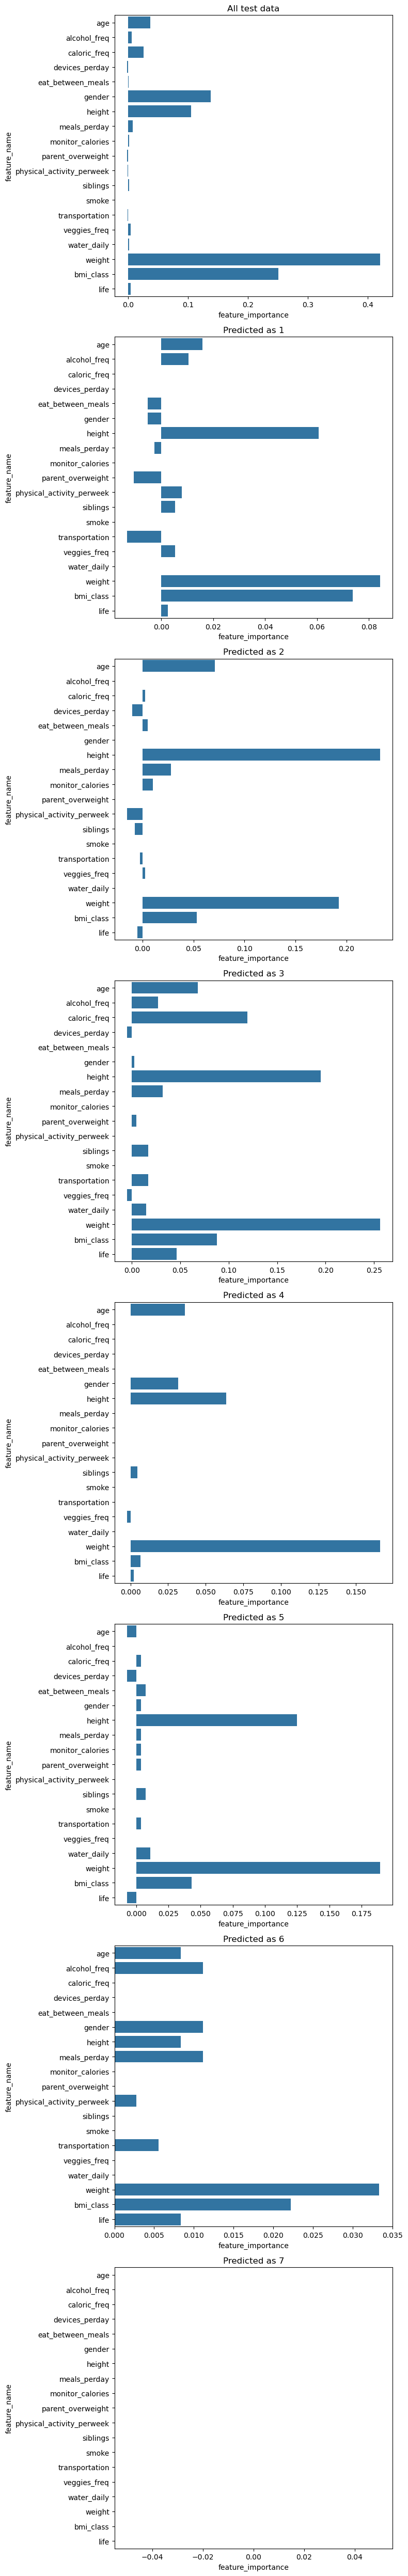

In [ ]:
def plot_feature_importances(model, x, y, title, ax):
    result = permutation_importance(model, x, y, n_repeats=5)
    df = pd.DataFrame({'feature_name': cols, 'feature_importance': result.importances_mean, 'feature_std': result.importances_std})
    sns.barplot(data=df, x='feature_importance', y='feature_name',errorbar="ci", ci="sd", ax=ax)
    ax.set_title(title)


z = np.unique(y_pred)
fig, axes = plt.subplots(len(z)+1,1, figsize=(8, 50))
plot_feature_importances(rf, X_test, y_test, 'All test data', ax=axes[0])

for i,C in enumerate(z):
    plot_feature_importances(rf, X_test[y_pred == C], y_test[y_pred == C], f'Predicted as {C}', axes[i+1])
    print(i+1, C)

plt.tight_layout()
plt.show()